In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from backtest import FixedThresholdPairsTrader, DynamicThresholdPairsTrader

In [2]:
ALL_INDICES = "^GSPC ^DJI ^IXIC ^NYA ^XAX ^RUT ^FTSE ^GDAXI ^FCHI ^N100 ^BFX ^N225 ^HSI 000001.SS 399001.SZ ^STI ^AXJO ^AORD ^BSESN ^JKSE ^KLSE ^NZ50 ^KS11 ^TWII ^GSPTSE ^BVSP ^MXX ^IPSA ^MERV"
START_DATE = "2010-01-01"
END_DATE = "2018-01-01"
BAD_INDICES = "^BUK100P ^STOXX50E ^VIX IMOEX.ME ^JN0U.JO"

all_data = yf.download(ALL_INDICES, start=START_DATE, end=END_DATE)
close_data = all_data["Adj Close"].dropna()

log_prices = np.log(close_data)
log_prices

[*********************100%***********************]  29 of 29 completed


000001.SS  399001.SZ     ^AORD     ^AXJO      ^BFX     ^BSESN  \
Date                                                                        
2010-01-05   8.096263   9.511720  8.505019  8.501937  7.858552   9.780542   
2010-01-06   8.087706   9.510817  8.506496  8.501348  7.861893   9.781384   
2010-01-07   8.068646   9.490645  8.503196  8.496868  7.859676   9.776547   
2010-01-08   8.069654   9.493057  8.505566  8.499457  7.860046   9.772256   
2010-01-12   8.093757   9.501599  8.503419  8.496888  7.849733   9.765518   
...               ...        ...       ...       ...       ...        ...   
2017-12-19   8.100628   9.312441  8.726351  8.711410  8.299254  10.429302   
2017-12-21   8.101696   9.316339  8.725231  8.709531  8.293049  10.426922   
2017-12-22   8.100787   9.314170  8.727016  8.711064  8.292811  10.432358   
2017-12-27   8.094312   9.297542  8.727406  8.711097  8.294817  10.431519   
2017-12-28   8.100582   9.303281  8.730593  8.714091  8.291887  10.429636   

                ^BVSP       ^DJI     ^FCHI     ^FTSE  ...      ^MERV  \
Date                                                  ...              
2010-01-05  11.159673   9.265966  8.297272  8.616586  ...   7.783974   
2010-01-06  11.166611   9.266123  8.298457  8.617943  ...   7.767476   
2010-01-07  11.162673   9.269256  8.300231  8.617346  ...   7.778839   
2010-01-08  11.160001   9.270324  8.305271  8.618702  ...   7.763361   
2010-01-12  11.157336   9.271178  8.294062  8.612267  ...   7.727755   
...               ...        ...       ...       ...  ...        ...   
2017-12-19  11.193822  10.116773  8.590984  8.928521  ...  10.229430   
2017-12-21  11.227015  10.117885  8.591553  8.936430  ...  10.256982   
2017-12-22  11.227734  10.116745  8.587600  8.934943  ...  10.272686   
2017-12-27  11.239449  10.117562  8.588367  8.938624  ...  10.281701   
2017-12-28  11.243764  10.120110  8.582872  8.938912  ...  10.308102   

                 ^MXX     ^N100      ^N225      ^NYA     ^NZ50      ^RUT  \
Date                                                                       
2010-01-05  10.396132  6.547603   9.276299  8.903118  8.091992  6.459106   
2010-01-06  10.399103  6.548606   9.280934  8.906217  8.093025  6.458260   
2010-01-07  10.406218  6.547875   9.276284  8.908415  8.097064  6.464542   
2010-01-08  10.400986  6.553050   9.287146  8.912655  8.104773  6.468568   
2010-01-12  10.397960  6.541751   9.294602  8.905234  8.098731  6.454412   
...               ...       ...        ...       ...       ...       ...   
2017-12-19  10.787318  6.952681  10.037494  9.453094  9.036130  7.337425   
2017-12-21  10.789387  6.950652  10.037411  9.457217  9.031745  7.344144   
2017-12-22  10.787006  6.947976  10.039013  9.457000  9.035562  7.341439   
2017-12-27  10.792460  6.948897  10.039382  9.458917  9.033177  7.342093   
2017-12-28  10.796754  6.944155  10.033813  9.461340  9.037002  7.345320   

                ^STI     ^TWII      ^XAX  
Date                                      
2010-01-05  7.979435  9.013275  7.528289  
2010-01-06  7.982925  9.027329  7.532035  
2010-01-07  7.977025  9.016439  7.532634  
2010-01-08  7.980284  9.021703  7.535030  
2010-01-12  7.978006  9.025135  7.536012  
...              ...       ...       ...  
2017-12-19  8.132845  9.256015  7.853104  
2017-12-21  8.126379  9.258079  7.864297  
2017-12-22  8.127319  9.262674  7.869581  
2017-12-27  8.129078  9.257860  7.881817  
2017-12-28  8.131266  9.265552  7.889088  

[1211 rows x 29 columns]

In [3]:
# test for stationarity 
# Johansen test is used to check for cointegraion between time series that are non-stationary
non_stationary_TS = []
from statsmodels.tsa.stattools import adfuller
for prices in log_prices:
    ADF = adfuller(log_prices[prices])
    p_value = ADF[1]
    if p_value > 0.05:
        non_stationary_TS.append(prices)
print("# of non stationary time series = ", len(non_stationary_TS)) 
non_stationary_TS

# of non stationary time series =  29


['000001.SS',
 '399001.SZ',
 '^AORD',
 '^AXJO',
 '^BFX',
 '^BSESN',
 '^BVSP',
 '^DJI',
 '^FCHI',
 '^FTSE',
 '^GDAXI',
 '^GSPC',
 '^GSPTSE',
 '^HSI',
 '^IPSA',
 '^IXIC',
 '^JKSE',
 '^KLSE',
 '^KS11',
 '^MERV',
 '^MXX',
 '^N100',
 '^N225',
 '^NYA',
 '^NZ50',
 '^RUT',
 '^STI',
 '^TWII',
 '^XAX']

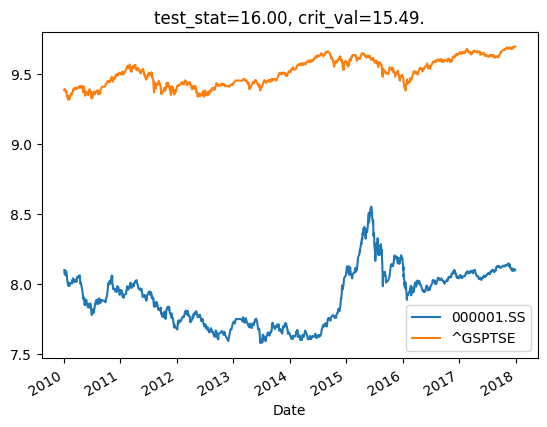

====== Selected Pair: ('000001.SS', '^GSPTSE') ======
	   trace_test_stat=16.00, trace_test_crit_val=15.49,
	   max_eig_test_stat=12.04, max_eig_test_crit_val=14.26.



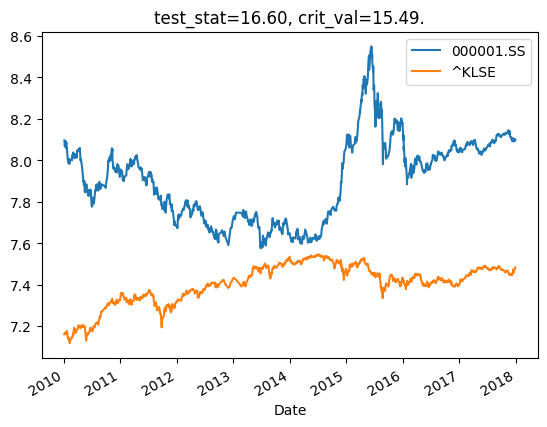

====== Selected Pair: ('000001.SS', '^KLSE') ======
	   trace_test_stat=16.60, trace_test_crit_val=15.49,
	   max_eig_test_stat=12.18, max_eig_test_crit_val=14.26.



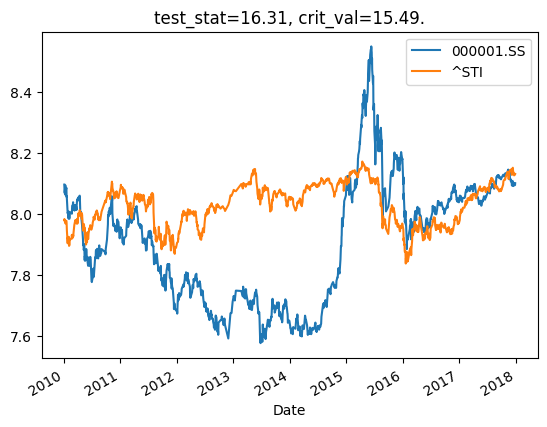

====== Selected Pair: ('000001.SS', '^STI') ======
	   trace_test_stat=16.31, trace_test_crit_val=15.49,
	   max_eig_test_stat=12.50, max_eig_test_crit_val=14.26.



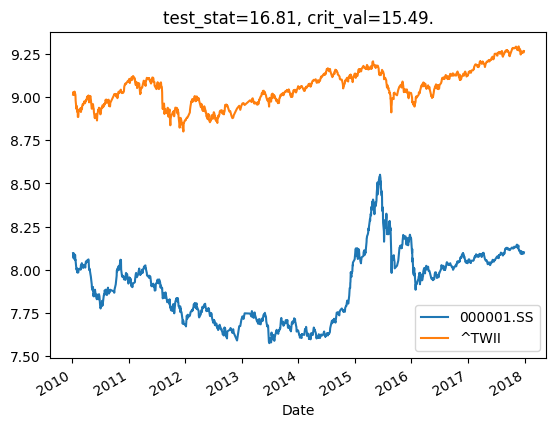

====== Selected Pair: ('000001.SS', '^TWII') ======
	   trace_test_stat=16.81, trace_test_crit_val=15.49,
	   max_eig_test_stat=13.34, max_eig_test_crit_val=14.26.



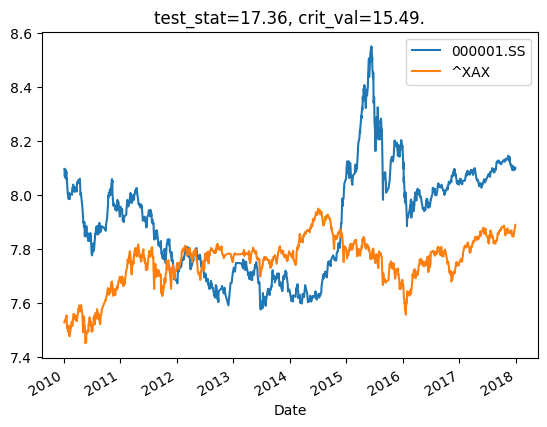

====== Selected Pair: ('000001.SS', '^XAX') ======
	   trace_test_stat=17.36, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.19, max_eig_test_crit_val=14.26.



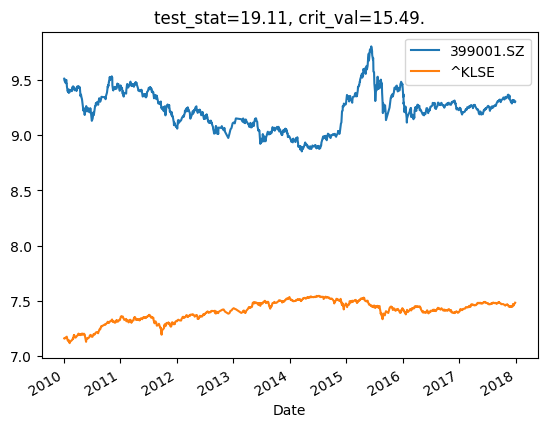

====== Selected Pair: ('399001.SZ', '^KLSE') ======
	   trace_test_stat=19.11, trace_test_crit_val=15.49,
	   max_eig_test_stat=13.17, max_eig_test_crit_val=14.26.



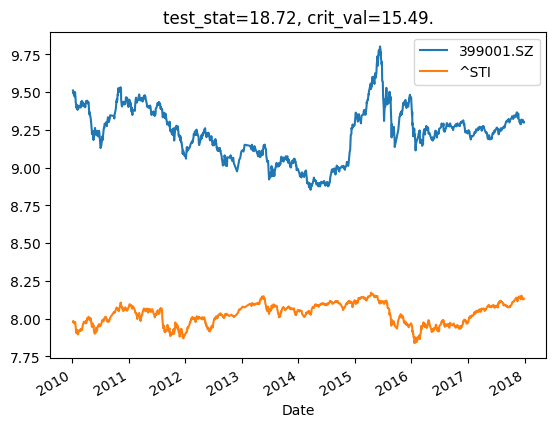

====== Selected Pair: ('399001.SZ', '^STI') ======
	   trace_test_stat=18.72, trace_test_crit_val=15.49,
	   max_eig_test_stat=10.97, max_eig_test_crit_val=14.26.



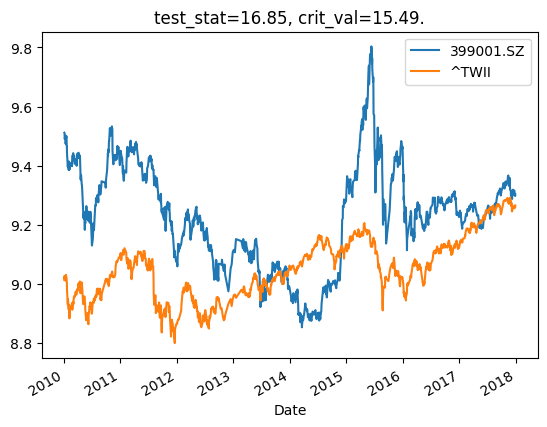

====== Selected Pair: ('399001.SZ', '^TWII') ======
	   trace_test_stat=16.85, trace_test_crit_val=15.49,
	   max_eig_test_stat=10.79, max_eig_test_crit_val=14.26.



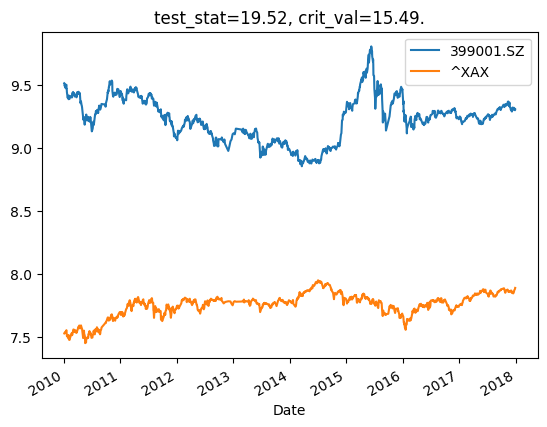

====== Selected Pair: ('399001.SZ', '^XAX') ======
	   trace_test_stat=19.52, trace_test_crit_val=15.49,
	   max_eig_test_stat=13.39, max_eig_test_crit_val=14.26.



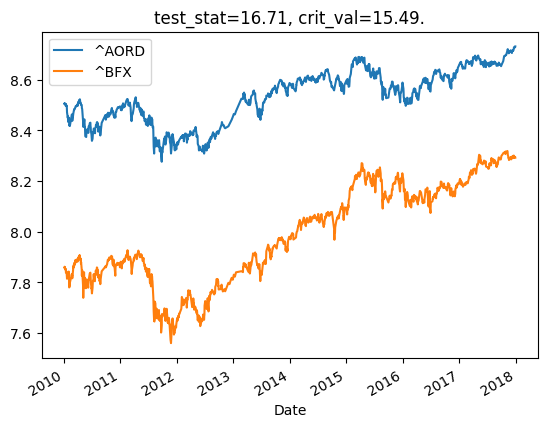

====== Selected Pair: ('^AORD', '^BFX') ======
	   trace_test_stat=16.71, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.03, max_eig_test_crit_val=14.26.



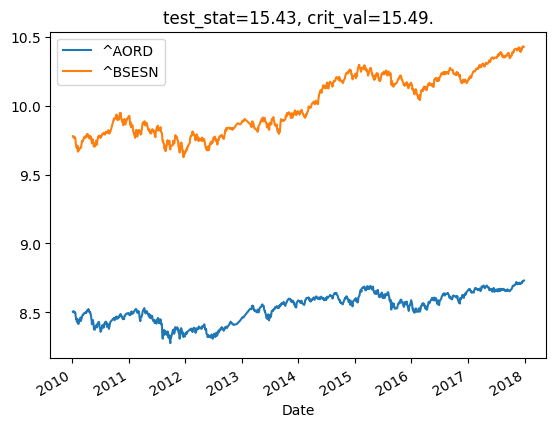

====== Selected Pair: ('^AORD', '^BSESN') ======
	   trace_test_stat=15.43, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.23, max_eig_test_crit_val=14.26.



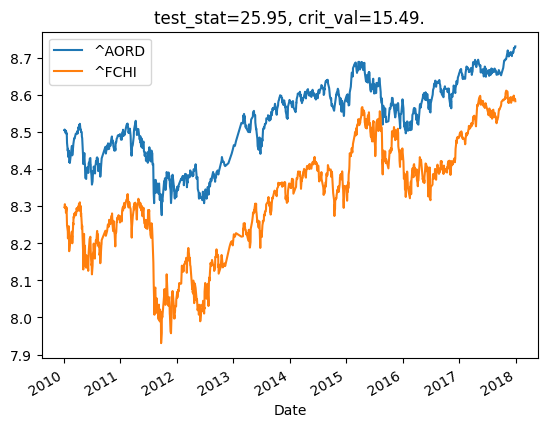

====== Selected Pair: ('^AORD', '^FCHI') ======
	   trace_test_stat=25.95, trace_test_crit_val=15.49,
	   max_eig_test_stat=24.38, max_eig_test_crit_val=14.26.



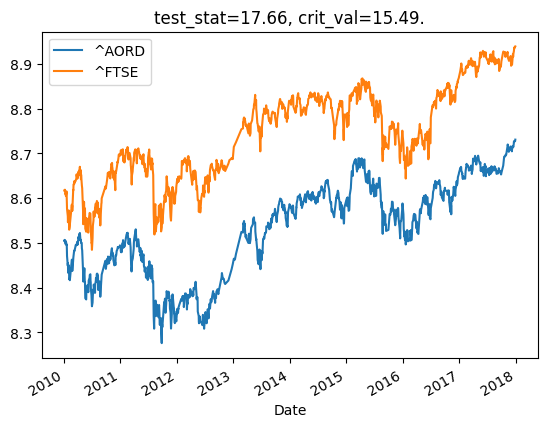

====== Selected Pair: ('^AORD', '^FTSE') ======
	   trace_test_stat=17.66, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.73, max_eig_test_crit_val=14.26.



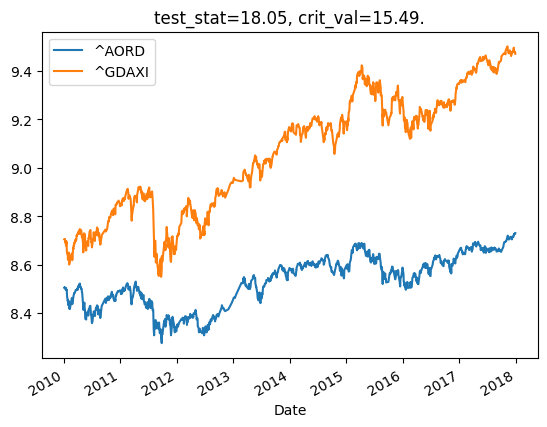

====== Selected Pair: ('^AORD', '^GDAXI') ======
	   trace_test_stat=18.05, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.23, max_eig_test_crit_val=14.26.



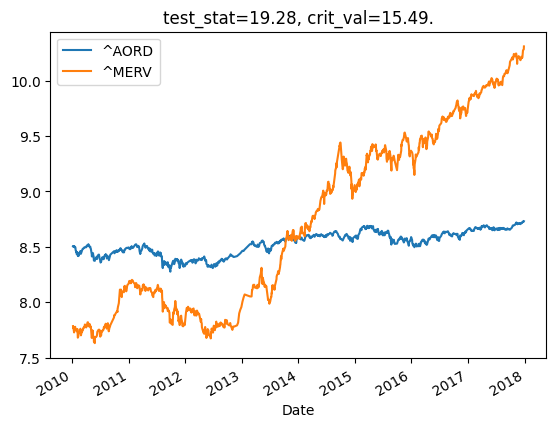

====== Selected Pair: ('^AORD', '^MERV') ======
	   trace_test_stat=19.28, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.16, max_eig_test_crit_val=14.26.



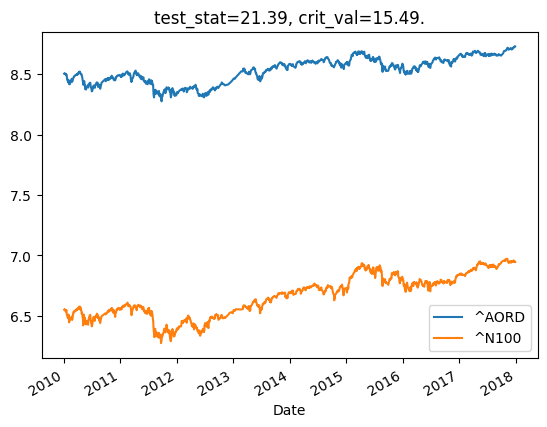

====== Selected Pair: ('^AORD', '^N100') ======
	   trace_test_stat=21.39, trace_test_crit_val=15.49,
	   max_eig_test_stat=20.36, max_eig_test_crit_val=14.26.



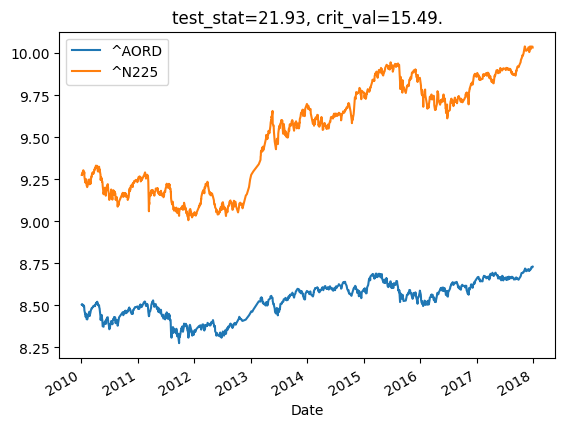

====== Selected Pair: ('^AORD', '^N225') ======
	   trace_test_stat=21.93, trace_test_crit_val=15.49,
	   max_eig_test_stat=21.73, max_eig_test_crit_val=14.26.



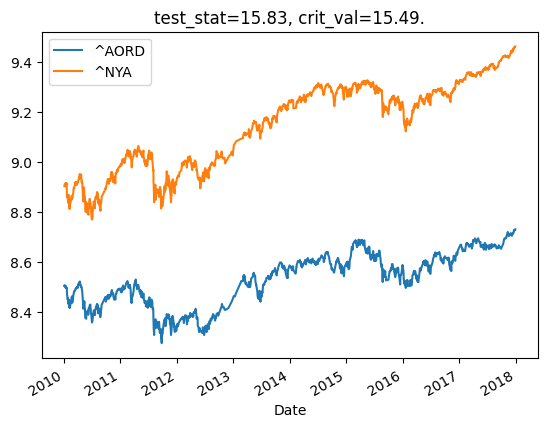

====== Selected Pair: ('^AORD', '^NYA') ======
	   trace_test_stat=15.83, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.96, max_eig_test_crit_val=14.26.



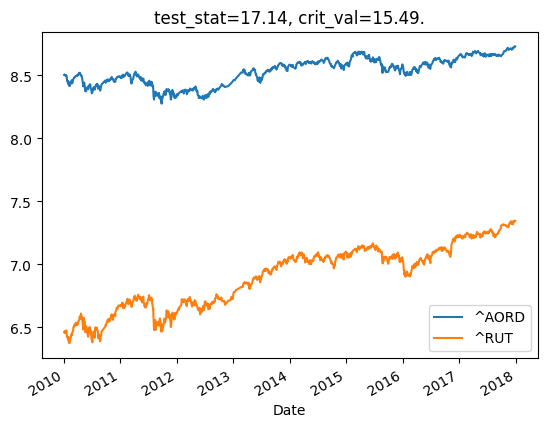

====== Selected Pair: ('^AORD', '^RUT') ======
	   trace_test_stat=17.14, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.00, max_eig_test_crit_val=14.26.



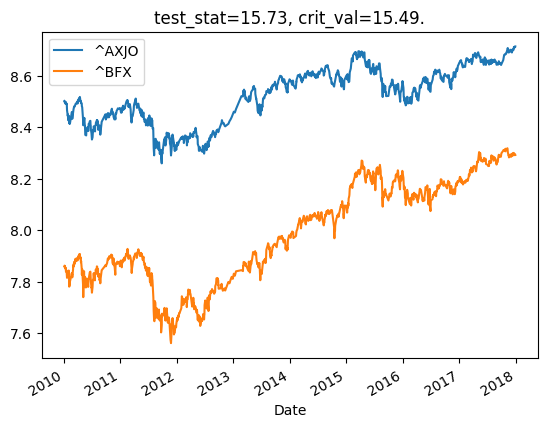

====== Selected Pair: ('^AXJO', '^BFX') ======
	   trace_test_stat=15.73, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.00, max_eig_test_crit_val=14.26.



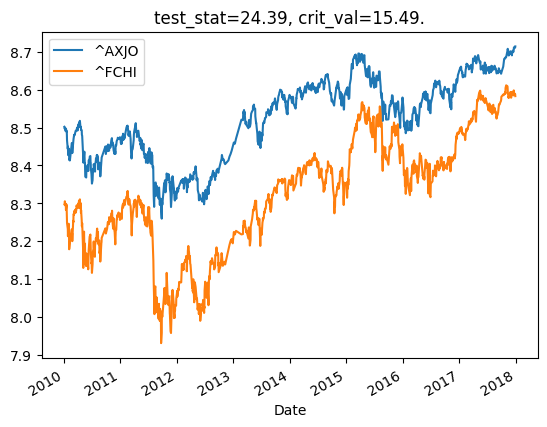

====== Selected Pair: ('^AXJO', '^FCHI') ======
	   trace_test_stat=24.39, trace_test_crit_val=15.49,
	   max_eig_test_stat=22.62, max_eig_test_crit_val=14.26.



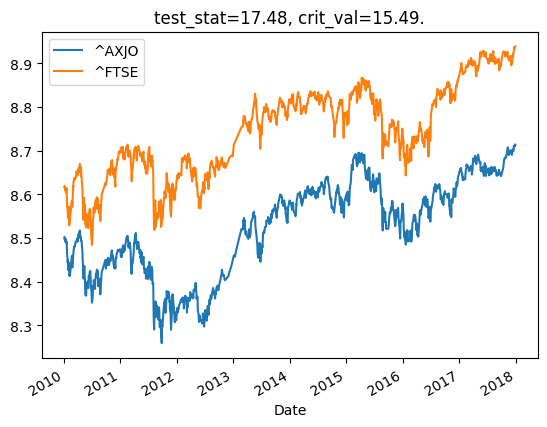

====== Selected Pair: ('^AXJO', '^FTSE') ======
	   trace_test_stat=17.48, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.51, max_eig_test_crit_val=14.26.



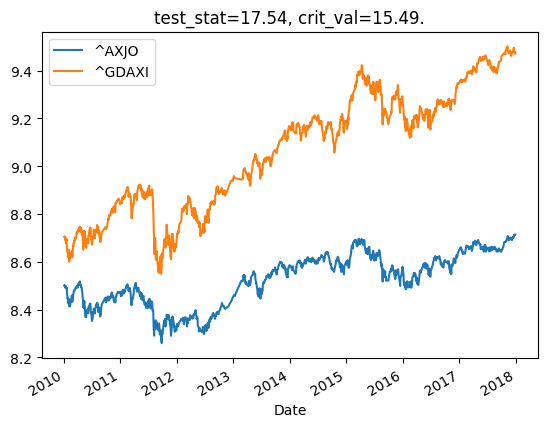

====== Selected Pair: ('^AXJO', '^GDAXI') ======
	   trace_test_stat=17.54, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.74, max_eig_test_crit_val=14.26.



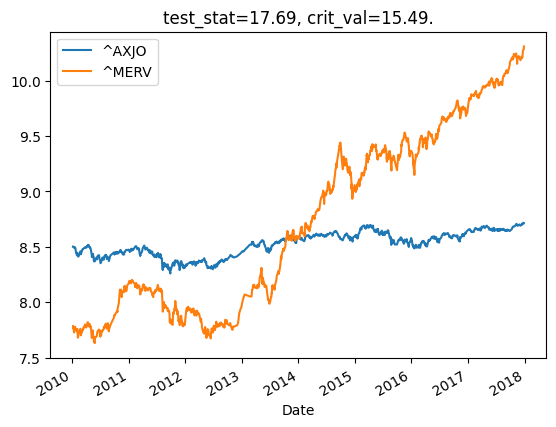

====== Selected Pair: ('^AXJO', '^MERV') ======
	   trace_test_stat=17.69, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.60, max_eig_test_crit_val=14.26.



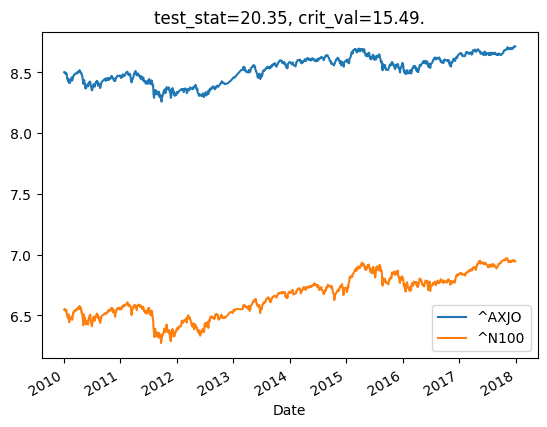

====== Selected Pair: ('^AXJO', '^N100') ======
	   trace_test_stat=20.35, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.23, max_eig_test_crit_val=14.26.



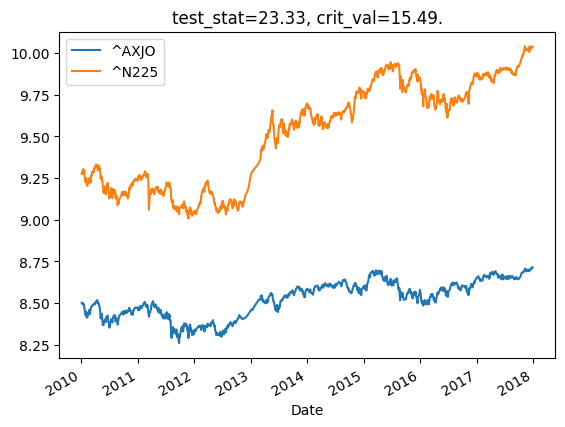

====== Selected Pair: ('^AXJO', '^N225') ======
	   trace_test_stat=23.33, trace_test_crit_val=15.49,
	   max_eig_test_stat=23.07, max_eig_test_crit_val=14.26.



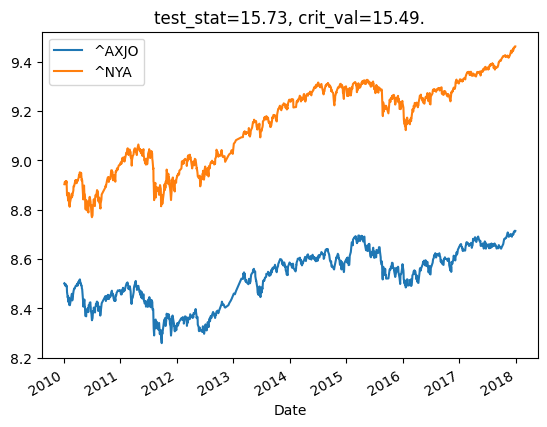

====== Selected Pair: ('^AXJO', '^NYA') ======
	   trace_test_stat=15.73, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.89, max_eig_test_crit_val=14.26.



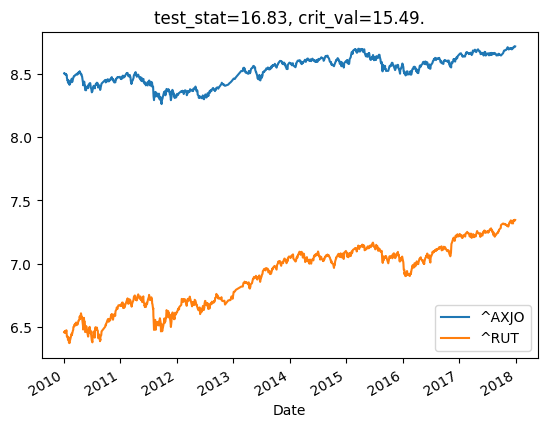

====== Selected Pair: ('^AXJO', '^RUT') ======
	   trace_test_stat=16.83, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.72, max_eig_test_crit_val=14.26.



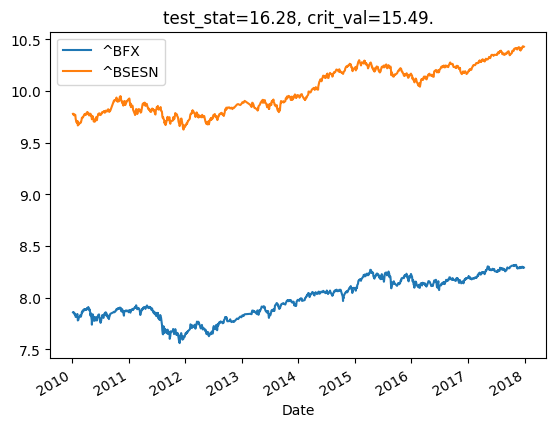

====== Selected Pair: ('^BFX', '^BSESN') ======
	   trace_test_stat=16.28, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.12, max_eig_test_crit_val=14.26.



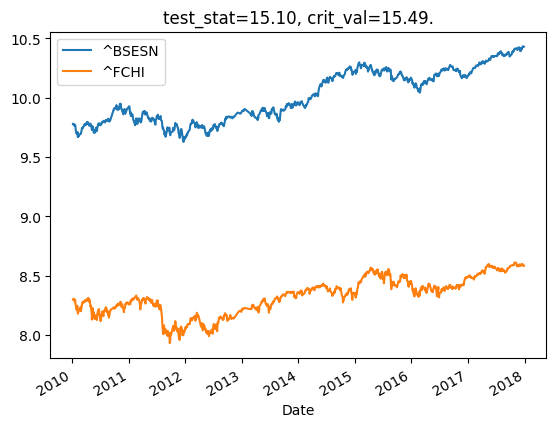

====== Selected Pair: ('^BSESN', '^FCHI') ======
	   trace_test_stat=15.10, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.85, max_eig_test_crit_val=14.26.



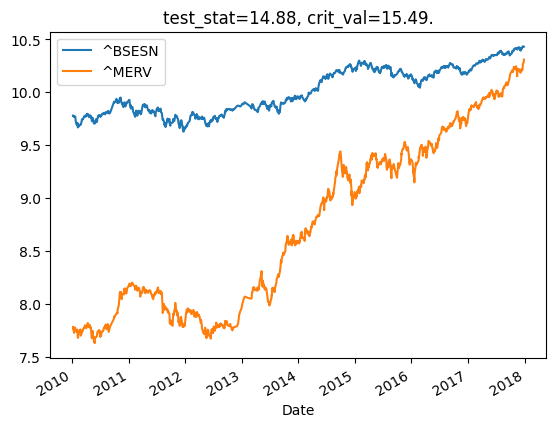

====== Selected Pair: ('^BSESN', '^MERV') ======
	   trace_test_stat=14.88, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.69, max_eig_test_crit_val=14.26.



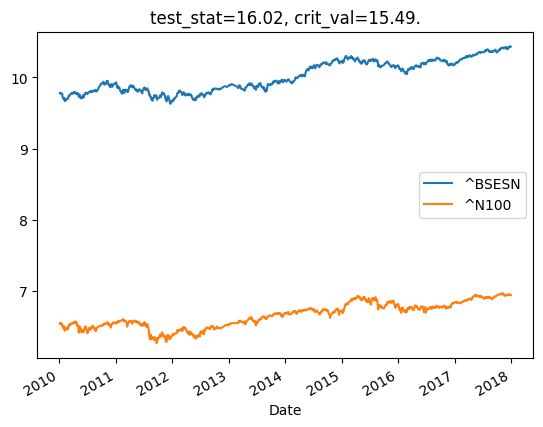

====== Selected Pair: ('^BSESN', '^N100') ======
	   trace_test_stat=16.02, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.81, max_eig_test_crit_val=14.26.



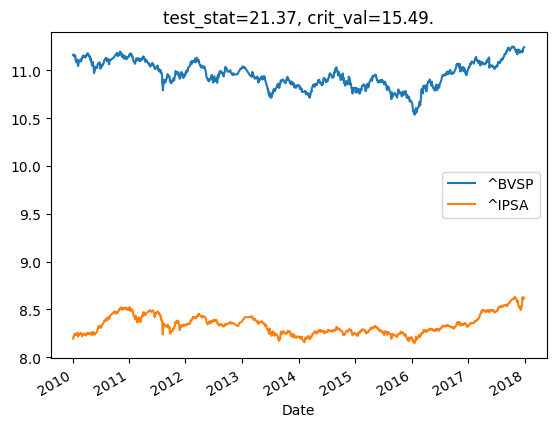

====== Selected Pair: ('^BVSP', '^IPSA') ======
	   trace_test_stat=21.37, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.76, max_eig_test_crit_val=14.26.



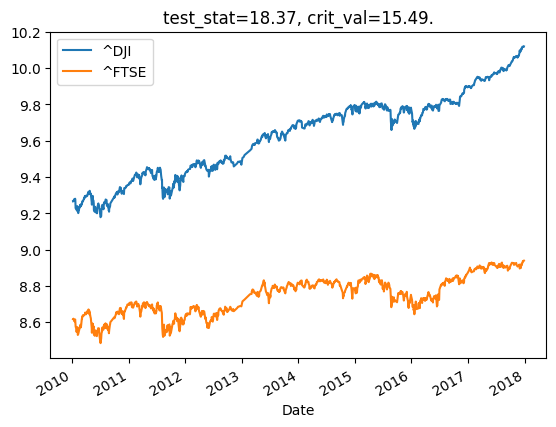

====== Selected Pair: ('^DJI', '^FTSE') ======
	   trace_test_stat=18.37, trace_test_crit_val=15.49,
	   max_eig_test_stat=18.37, max_eig_test_crit_val=14.26.



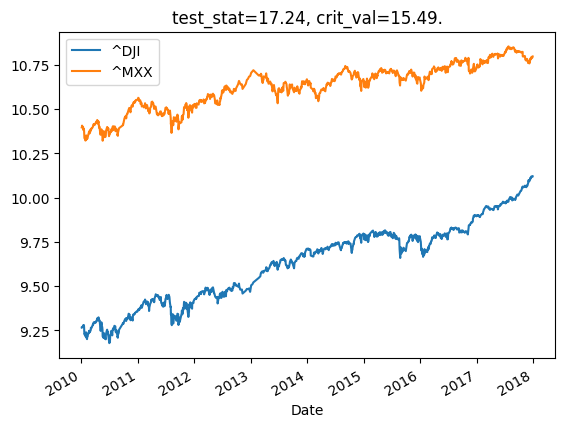

====== Selected Pair: ('^DJI', '^MXX') ======
	   trace_test_stat=17.24, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.05, max_eig_test_crit_val=14.26.



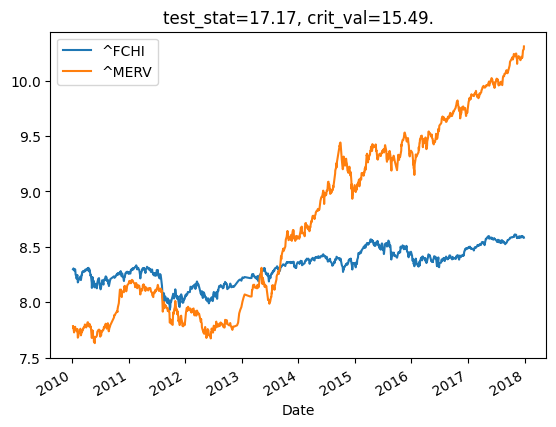

====== Selected Pair: ('^FCHI', '^MERV') ======
	   trace_test_stat=17.17, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.01, max_eig_test_crit_val=14.26.



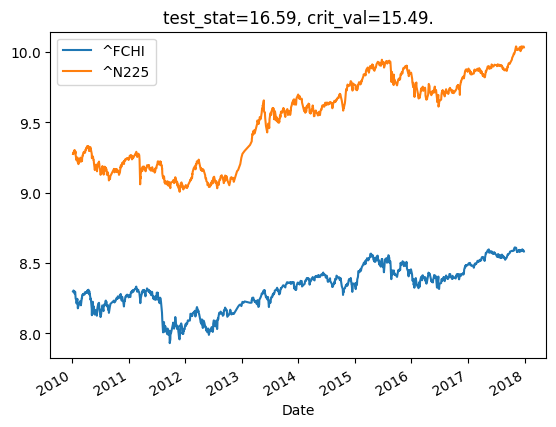

====== Selected Pair: ('^FCHI', '^N225') ======
	   trace_test_stat=16.59, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.45, max_eig_test_crit_val=14.26.



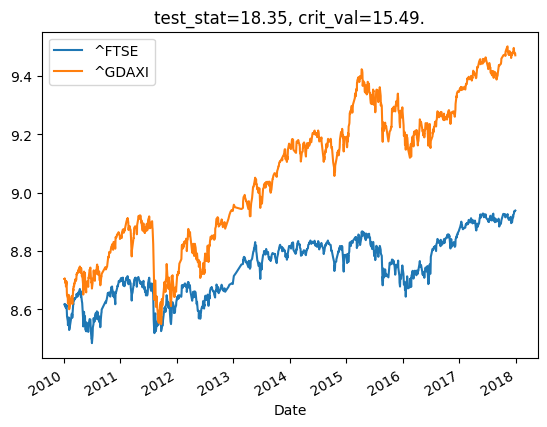

====== Selected Pair: ('^FTSE', '^GDAXI') ======
	   trace_test_stat=18.35, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.40, max_eig_test_crit_val=14.26.



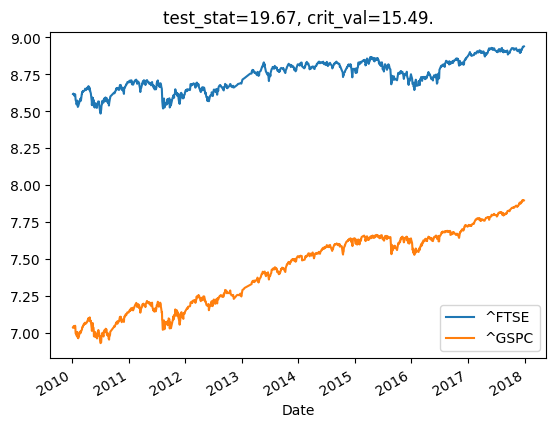

====== Selected Pair: ('^FTSE', '^GSPC') ======
	   trace_test_stat=19.67, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.52, max_eig_test_crit_val=14.26.



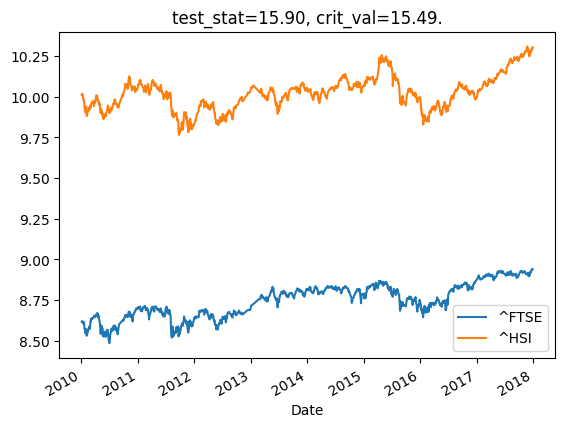

====== Selected Pair: ('^FTSE', '^HSI') ======
	   trace_test_stat=15.90, trace_test_crit_val=15.49,
	   max_eig_test_stat=10.63, max_eig_test_crit_val=14.26.



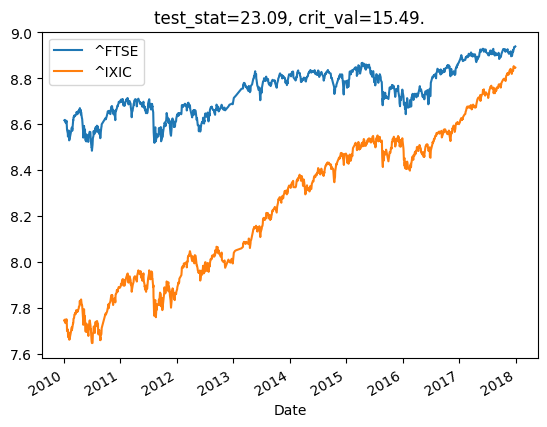

====== Selected Pair: ('^FTSE', '^IXIC') ======
	   trace_test_stat=23.09, trace_test_crit_val=15.49,
	   max_eig_test_stat=22.98, max_eig_test_crit_val=14.26.



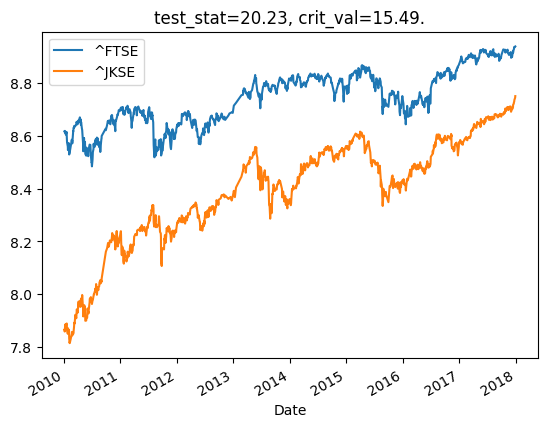

====== Selected Pair: ('^FTSE', '^JKSE') ======
	   trace_test_stat=20.23, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.15, max_eig_test_crit_val=14.26.



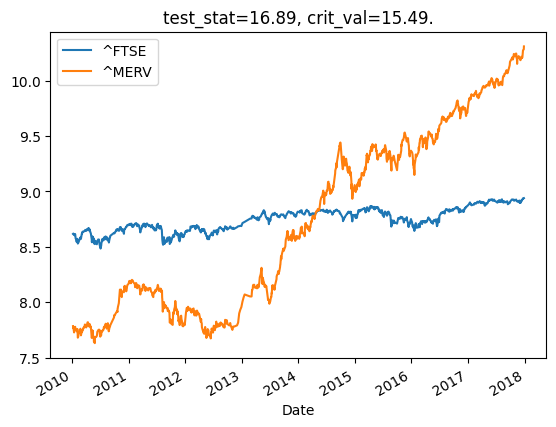

====== Selected Pair: ('^FTSE', '^MERV') ======
	   trace_test_stat=16.89, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.81, max_eig_test_crit_val=14.26.



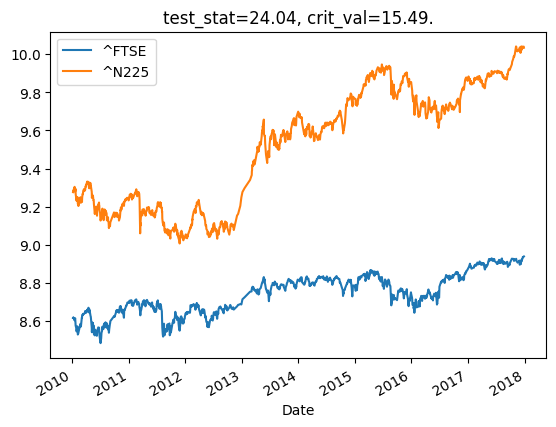

====== Selected Pair: ('^FTSE', '^N225') ======
	   trace_test_stat=24.04, trace_test_crit_val=15.49,
	   max_eig_test_stat=23.43, max_eig_test_crit_val=14.26.



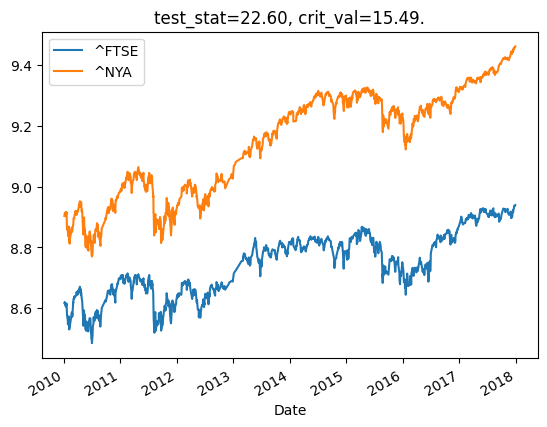

====== Selected Pair: ('^FTSE', '^NYA') ======
	   trace_test_stat=22.60, trace_test_crit_val=15.49,
	   max_eig_test_stat=21.91, max_eig_test_crit_val=14.26.



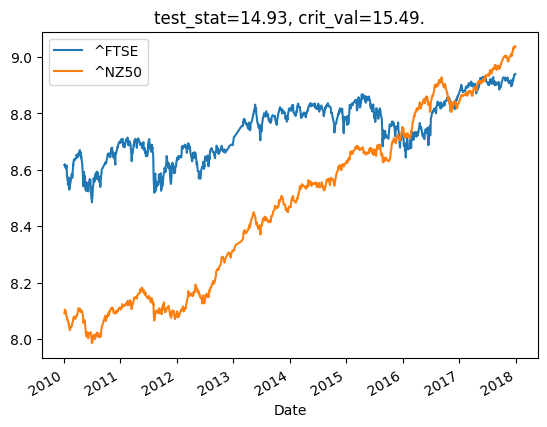

====== Selected Pair: ('^FTSE', '^NZ50') ======
	   trace_test_stat=14.93, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.48, max_eig_test_crit_val=14.26.



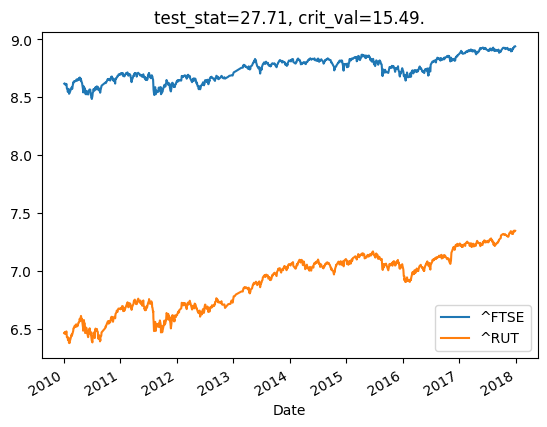

====== Selected Pair: ('^FTSE', '^RUT') ======
	   trace_test_stat=27.71, trace_test_crit_val=15.49,
	   max_eig_test_stat=26.59, max_eig_test_crit_val=14.26.



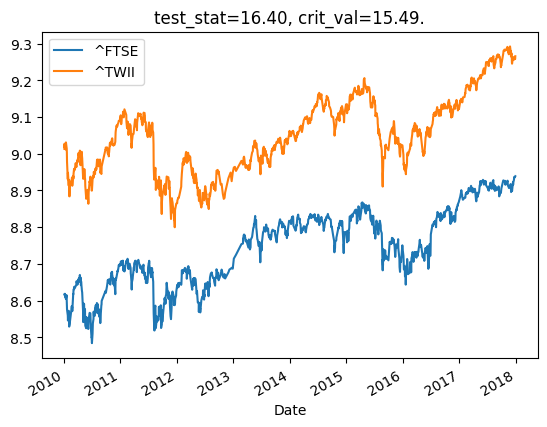

====== Selected Pair: ('^FTSE', '^TWII') ======
	   trace_test_stat=16.40, trace_test_crit_val=15.49,
	   max_eig_test_stat=13.56, max_eig_test_crit_val=14.26.



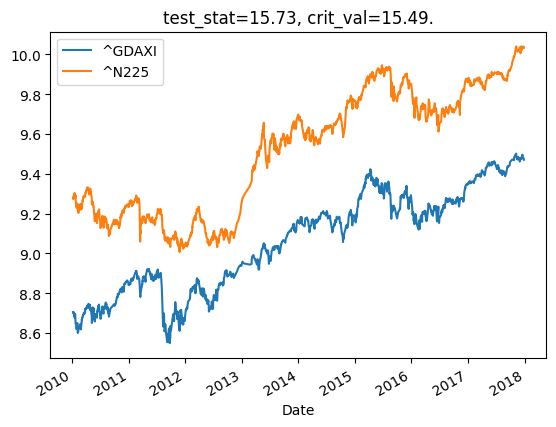

====== Selected Pair: ('^GDAXI', '^N225') ======
	   trace_test_stat=15.73, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.17, max_eig_test_crit_val=14.26.



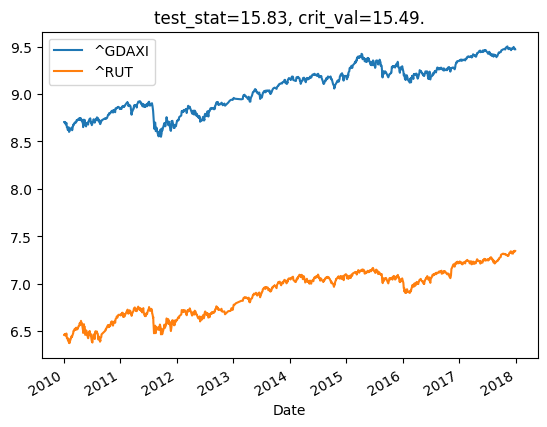

====== Selected Pair: ('^GDAXI', '^RUT') ======
	   trace_test_stat=15.83, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.78, max_eig_test_crit_val=14.26.



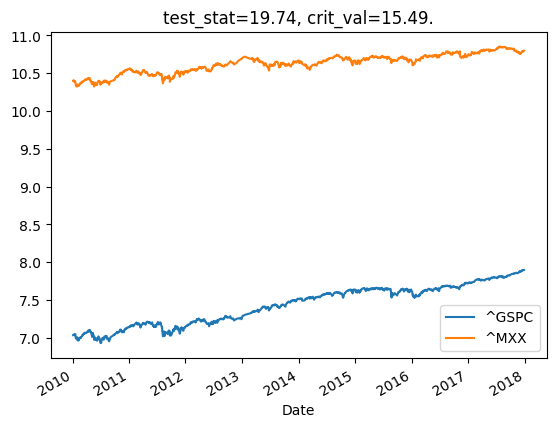

====== Selected Pair: ('^GSPC', '^MXX') ======
	   trace_test_stat=19.74, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.26, max_eig_test_crit_val=14.26.



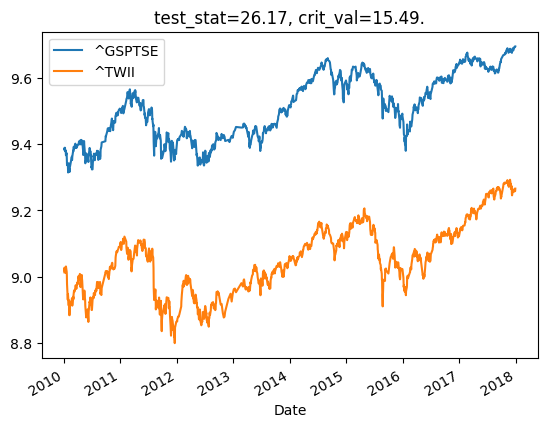

====== Selected Pair: ('^GSPTSE', '^TWII') ======
	   trace_test_stat=26.17, trace_test_crit_val=15.49,
	   max_eig_test_stat=24.37, max_eig_test_crit_val=14.26.



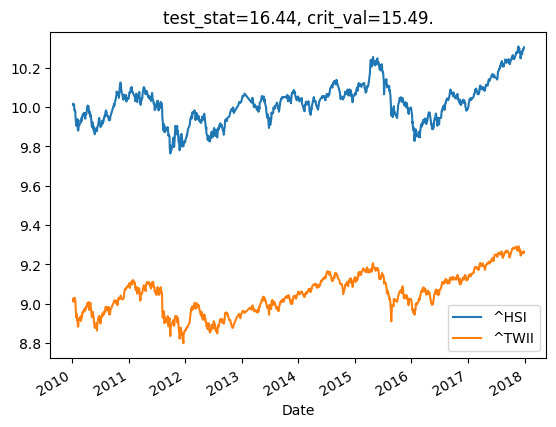

====== Selected Pair: ('^HSI', '^TWII') ======
	   trace_test_stat=16.44, trace_test_crit_val=15.49,
	   max_eig_test_stat=13.79, max_eig_test_crit_val=14.26.



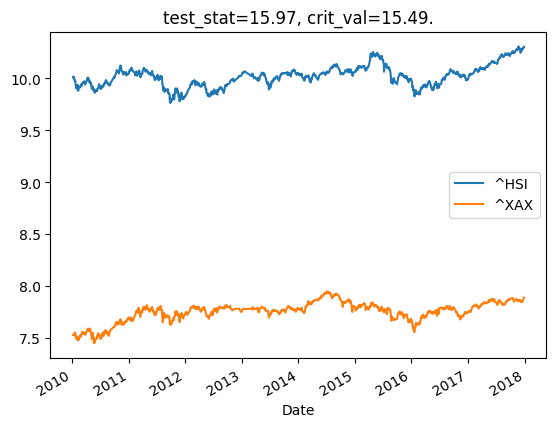

====== Selected Pair: ('^HSI', '^XAX') ======
	   trace_test_stat=15.97, trace_test_crit_val=15.49,
	   max_eig_test_stat=12.63, max_eig_test_crit_val=14.26.



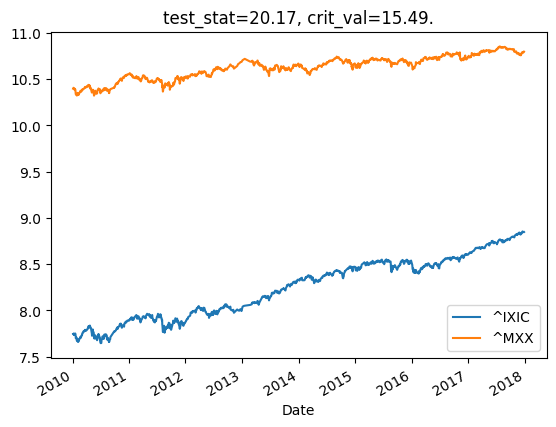

====== Selected Pair: ('^IXIC', '^MXX') ======
	   trace_test_stat=20.17, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.79, max_eig_test_crit_val=14.26.



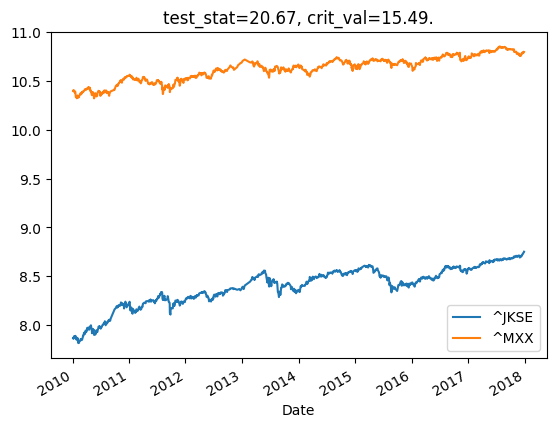

====== Selected Pair: ('^JKSE', '^MXX') ======
	   trace_test_stat=20.67, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.69, max_eig_test_crit_val=14.26.



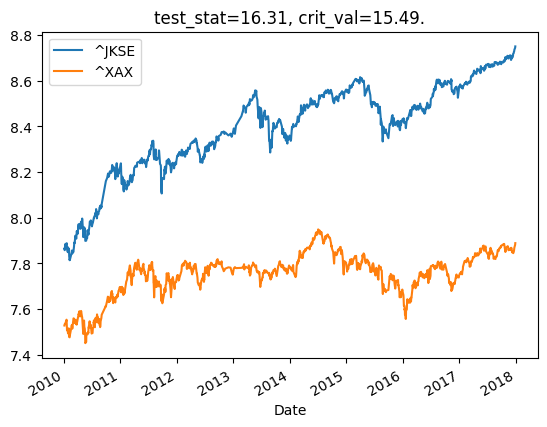

====== Selected Pair: ('^JKSE', '^XAX') ======
	   trace_test_stat=16.31, trace_test_crit_val=15.49,
	   max_eig_test_stat=12.63, max_eig_test_crit_val=14.26.



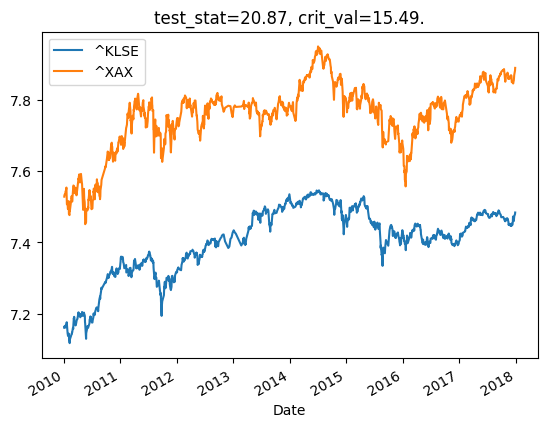

====== Selected Pair: ('^KLSE', '^XAX') ======
	   trace_test_stat=20.87, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.42, max_eig_test_crit_val=14.26.



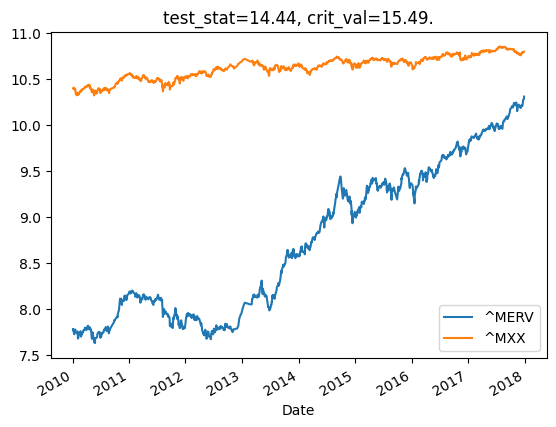

====== Selected Pair: ('^MERV', '^MXX') ======
	   trace_test_stat=14.44, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.44, max_eig_test_crit_val=14.26.



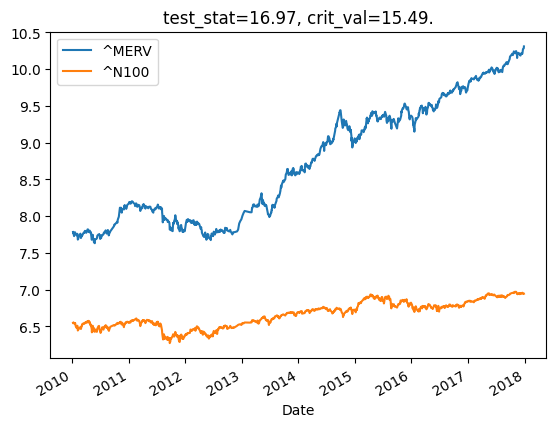

====== Selected Pair: ('^MERV', '^N100') ======
	   trace_test_stat=16.97, trace_test_crit_val=15.49,
	   max_eig_test_stat=16.88, max_eig_test_crit_val=14.26.



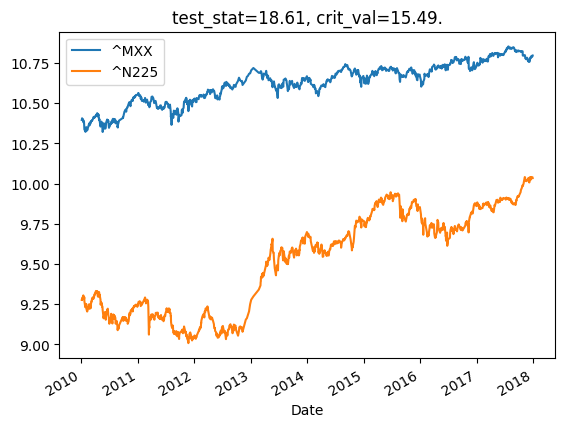

====== Selected Pair: ('^MXX', '^N225') ======
	   trace_test_stat=18.61, trace_test_crit_val=15.49,
	   max_eig_test_stat=17.17, max_eig_test_crit_val=14.26.



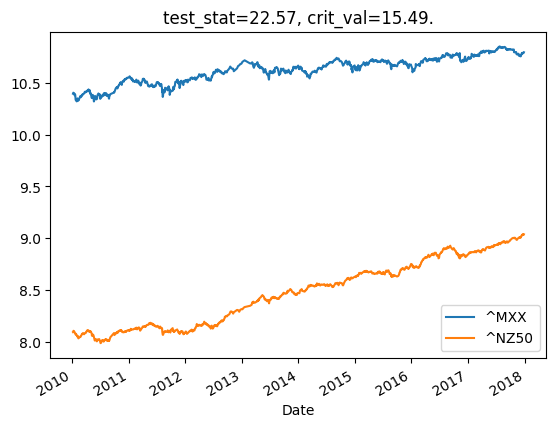

====== Selected Pair: ('^MXX', '^NZ50') ======
	   trace_test_stat=22.57, trace_test_crit_val=15.49,
	   max_eig_test_stat=22.53, max_eig_test_crit_val=14.26.



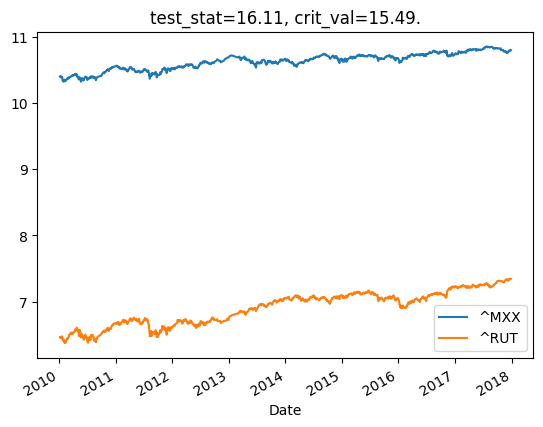

====== Selected Pair: ('^MXX', '^RUT') ======
	   trace_test_stat=16.11, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.48, max_eig_test_crit_val=14.26.



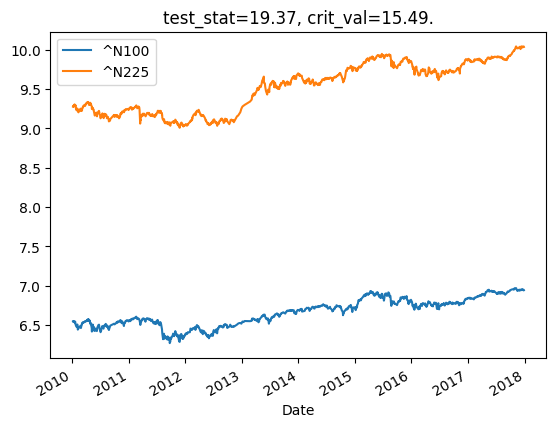

====== Selected Pair: ('^N100', '^N225') ======
	   trace_test_stat=19.37, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.19, max_eig_test_crit_val=14.26.



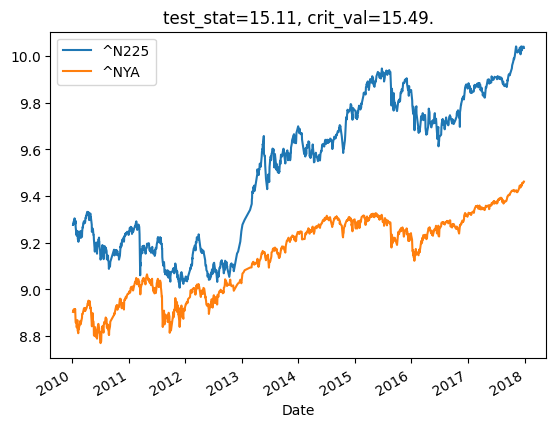

====== Selected Pair: ('^N225', '^NYA') ======
	   trace_test_stat=15.11, trace_test_crit_val=15.49,
	   max_eig_test_stat=14.42, max_eig_test_crit_val=14.26.



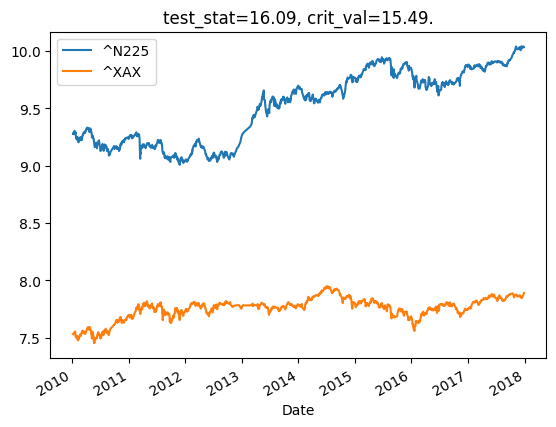

====== Selected Pair: ('^N225', '^XAX') ======
	   trace_test_stat=16.09, trace_test_crit_val=15.49,
	   max_eig_test_stat=15.59, max_eig_test_crit_val=14.26.



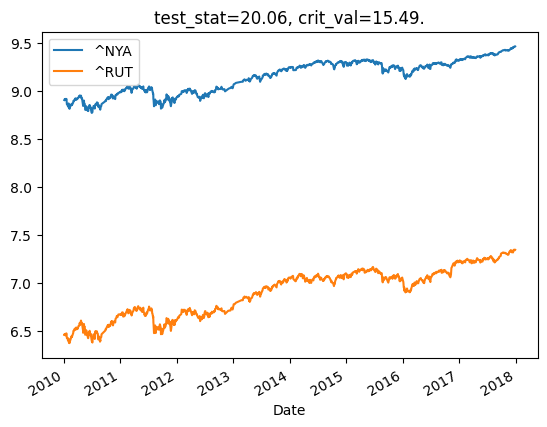

====== Selected Pair: ('^NYA', '^RUT') ======
	   trace_test_stat=20.06, trace_test_crit_val=15.49,
	   max_eig_test_stat=19.02, max_eig_test_crit_val=14.26.



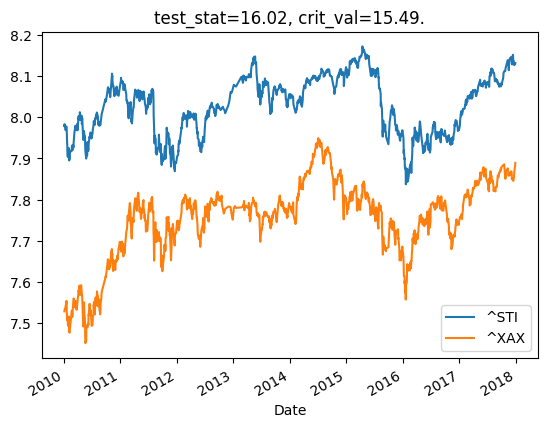

====== Selected Pair: ('^STI', '^XAX') ======
	   trace_test_stat=16.02, trace_test_crit_val=15.49,
	   max_eig_test_stat=9.48, max_eig_test_crit_val=14.26.



In [4]:
coint_test_results = dict()

selected_pairs = []

for pair in itertools.combinations(log_prices.columns, 2):
    pair_log_returns = log_prices.loc[:, pair]
    pair_test_results = coint_johansen(pair_log_returns, det_order=0, k_ar_diff=1)
    coint_test_results.update({pair: pair_test_results})

    trace_test_stat = pair_test_results.trace_stat[0]
    # The critical value corresponds to the 95%
    trace_test_crit_val = pair_test_results.trace_stat_crit_vals[0, 1]

    max_eig_test_stat = pair_test_results.max_eig_stat[0]
    max_eig_test_crit_val = pair_test_results.max_eig_stat_crit_vals[0, 1]

    if (trace_test_stat > trace_test_crit_val) or (max_eig_test_stat > max_eig_test_crit_val):
        selected_pairs.append(pair)
        fig, ax = plt.subplots(1, 1)
        ax = log_prices.loc[:, pair].plot(ax=ax)
        ax.set_title(f"test_stat={trace_test_stat:.2f}, crit_val={trace_test_crit_val:.2f}.")
        plt.show()

        print(f"====== Selected Pair: {pair} ======")
        print(f"\t   {trace_test_stat=:.2f}, {trace_test_crit_val=:.2f},")
        print(f"\t   {max_eig_test_stat=:.2f}, {max_eig_test_crit_val=:.2f}.\n")

In [5]:
selected_pairs

[('000001.SS', '^GSPTSE'),
 ('000001.SS', '^KLSE'),
 ('000001.SS', '^STI'),
 ('000001.SS', '^TWII'),
 ('000001.SS', '^XAX'),
 ('399001.SZ', '^KLSE'),
 ('399001.SZ', '^STI'),
 ('399001.SZ', '^TWII'),
 ('399001.SZ', '^XAX'),
 ('^AORD', '^BFX'),
 ('^AORD', '^BSESN'),
 ('^AORD', '^FCHI'),
 ('^AORD', '^FTSE'),
 ('^AORD', '^GDAXI'),
 ('^AORD', '^MERV'),
 ('^AORD', '^N100'),
 ('^AORD', '^N225'),
 ('^AORD', '^NYA'),
 ('^AORD', '^RUT'),
 ('^AXJO', '^BFX'),
 ('^AXJO', '^FCHI'),
 ('^AXJO', '^FTSE'),
 ('^AXJO', '^GDAXI'),
 ('^AXJO', '^MERV'),
 ('^AXJO', '^N100'),
 ('^AXJO', '^N225'),
 ('^AXJO', '^NYA'),
 ('^AXJO', '^RUT'),
 ('^BFX', '^BSESN'),
 ('^BSESN', '^FCHI'),
 ('^BSESN', '^MERV'),
 ('^BSESN', '^N100'),
 ('^BVSP', '^IPSA'),
 ('^DJI', '^FTSE'),
 ('^DJI', '^MXX'),
 ('^FCHI', '^MERV'),
 ('^FCHI', '^N225'),
 ('^FTSE', '^GDAXI'),
 ('^FTSE', '^GSPC'),
 ('^FTSE', '^HSI'),
 ('^FTSE', '^IXIC'),
 ('^FTSE', '^JKSE'),
 ('^FTSE', '^MERV'),
 ('^FTSE', '^N225'),
 ('^FTSE', '^NYA'),
 ('^FTSE', '^NZ50'),
 ('^

In [6]:
len(selected_pairs)

68

In [7]:
# # Below code is for Fixed threshold pairs trading 
# #- not practical as the entire test duration is used to select the thresholds
# # - useful ONLY for sanity checks.
# for asset1, asset2 in selected_pairs:
#     print(f"Selected pair: {asset1} and {asset2}.")
#     pairs_data = yf.download(f"{asset1} {asset2}", start="2008-01-01", end="2023-01-20")
#     prices_df = pairs_data["Adj Close"].dropna()
#     forward_returns_df = prices_df.pct_change().iloc[1:]
#     pairs_trader = FixedThresholdPairsTrader(prices_df)
#     positions_df_fixed_thresh = pairs_trader.backtest(use_hedge_ratio=False, entry_threshold=2.0, exit_threshold=0.0)
#     plt.figure()
#     plt.plot(positions_df_fixed_thresh.iloc[:, 0])
#     plt.ylabel(f"Position in {asset1}")
#     plt.show()

#     plt.figure()
#     plt.plot(positions_df_fixed_thresh.iloc[:, 1])
#     plt.ylabel(f"Position in {asset2}.")
#     plt.show()
#     # Crucial to delay positions to avoid lookahead bias
#     delayed_positions = positions_df_fixed_thresh.shift(1)[1:]
#     forward_returns = forward_returns_df.loc[delayed_positions.index]
#     strategy_returns = delayed_positions * forward_returns
#     daily_returns = strategy_returns.sum(axis=1)
#     ann_returns = daily_returns.mean()*252*100
#     ann_vol = daily_returns.std()*np.sqrt(252)*100
#     sharpe = ann_returns / ann_vol
#     turnover = delayed_positions.diff(1).abs().sum(axis=1).mean()*100

#     plt.figure()
#     plt.plot(delayed_positions.index, np.cumsum([np.log(1+r) for r in daily_returns]))
#     plt.ylabel(f"Cumulative log returns. ")
#     plt.title(f"Sharpe = {sharpe:.2f}, "
#                f"Ann Ret: {ann_returns:.2f}%, Ann. Vol: {ann_vol:.2f}%, Turnover: {turnover:.2f}%.")
#     plt.show()

#     plt.figure()
#     plt.plot(delayed_positions.index, np.cumprod([(1+r) for r in daily_returns]))
#     plt.ylabel(f"Growth. ")
#     plt.title(f"Sharpe = {sharpe:.2f}, "
#                f"Ann Ret: {ann_returns:.2f}%, Ann. Vol: {ann_vol:.2f}%, Turnover: {turnover:.2f}%.")
#     plt.show()

In [8]:
# # Below code is for Fixed threshold pairs trading (with trade function) 
# #- not practical as the entire test duration is used to select the thresholds
# # - useful ONLY for sanity checks.
# for asset1, asset2 in selected_pairs:
#     print(f"Selected pair: {asset1} and {asset2}.")
#     pairs_data = yf.download(f"{asset1} {asset2}", start="2008-01-01", end="2023-01-20")
#     prices_df = pairs_data["Adj Close"].dropna()
#     forward_returns_df = prices_df.pct_change().iloc[1:]
#     pairs_trader = FixedThresholdPairsTrader(prices_df)
#     actions_df_fixed_thresh = pairs_trader.backtest_actions(
#         entry_threshold=2.0, exit_threshold=0.0
#     )
#     dollar_portfolios = pairs_trader.pnl_actions(
#         actions_df_fixed_thresh,
#         future_returns_df=forward_returns_df,
#     )
#     plt.figure()
#     plt.plot(dollar_portfolios.sum(axis=1))
#     plt.show()

In [9]:
# # Dynamic threshold based pairs trading (old version)
# old_results = {}
# for asset1, asset2 in selected_pairs:
#     print(f"Selected pair: {asset1} and {asset2}.")
#     pairs_data = yf.download(f"{asset1} {asset2}", start="2008-01-01", end="2023-01-20")
#     prices_df = pairs_data["Adj Close"].dropna()
#     dynamic_thresh_pairs_trader = DynamicThresholdPairsTrader(prices_df)
#     forward_returns_df = prices_df.pct_change().iloc[1:]
#     portfolio_returns_dyn_thresh = dynamic_thresh_pairs_trader.backtest(
#         formation_period=63, testing_period=21, entry_threshold=2.0, exit_threshold=1.0, use_hedge_ratio=False
#     )
#     # The portfolio uses weights of 1 and -1 to create the spread instead of beta.
#     # Starting with $0 in cash, in order to buy the spread, we first borrow $1 worth of asset 2 and sell it then we have $1 in cash. 
#     # We will immediately then buy $1 worth of asset 1.
#     # This makes the portfolio self-financing and the cash is assumed to be 0 always in the simulation. 
    
#     # The hedge ratio is used only to create the *trading signal* but not the trades themselves.
    
#     #plt.figure()
#     #plt.plot(portfolio_returns_dyn_thresh.iloc[:, 0])
#     #plt.ylabel(f"Position in {asset1}")
#     #plt.show()

#     #plt.figure()
#     #plt.plot(portfolio_returns_dyn_thresh.iloc[:, 1])
#     #plt.ylabel(f"Position in {asset2}.")
#     #plt.show()
#     # Crucial to delay positions to avoid lookahead bias
#     delayed_positions = portfolio_returns_dyn_thresh.shift(1)[1:]
#     forward_returns = forward_returns_df.loc[delayed_positions.index]
#     strategy_returns = delayed_positions * forward_returns
#     daily_returns = strategy_returns.sum(axis=1)
#     ann_returns = daily_returns.mean()*252*100
#     ann_vol = daily_returns.std()*np.sqrt(252)*100
#     sharpe = ann_returns / ann_vol
#     turnover = delayed_positions.diff(1).abs().sum(axis=1).mean()*100

#     #plt.figure()
#     #plt.plot(delayed_positions.index, np.cumsum([np.log(1+r) for r in daily_returns]))
#     #plt.ylabel(f"Cumulative log returns. ")
#     #plt.title(f"Sharpe = {sharpe:.2f}, "
#                #f"Ann Ret: {ann_returns:.2f}%, Ann. Vol: {ann_vol:.2f}%, Turnover: {turnover:.2f}%.")
#     #plt.show()


#     plt.figure()
#     plt.plot(delayed_positions.index, np.cumprod([(1+r) for r in daily_returns]))
#     plt.ylabel(f"Growth. ")
#     plt.title(f"({asset1}, {asset2}) Sharpe = {sharpe:.2f}, "
#                f"Ann Ret: {ann_returns:.2f}%, Ann. Vol: {ann_vol:.2f}%, Turnover: {turnover:.2f}%.")
#     plt.show()
#     old_results.update({f"{asset1}-{asset2}": {"Sharpe" : sharpe,"Ann.Ret" : ann_returns, "Ann.Vol" : ann_vol, "Turnover" : turnover}})

Selected pair: 000001.SS and ^GSPTSE.
[*********************100%***********************]  2 of 2 completed


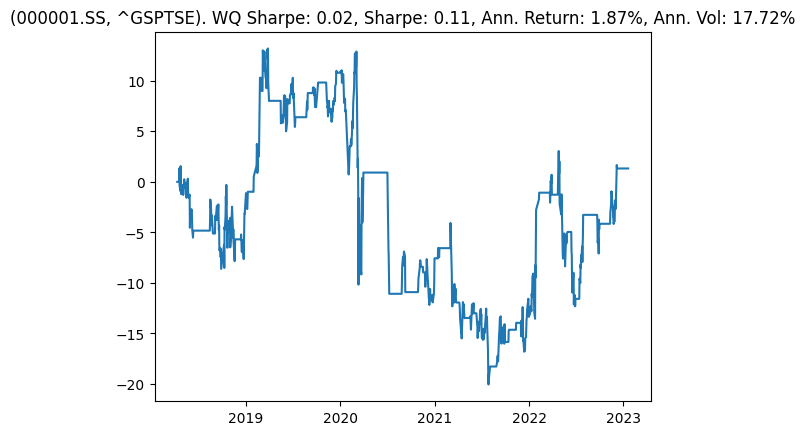

Selected pair: 000001.SS and ^KLSE.
[*********************100%***********************]  2 of 2 completed


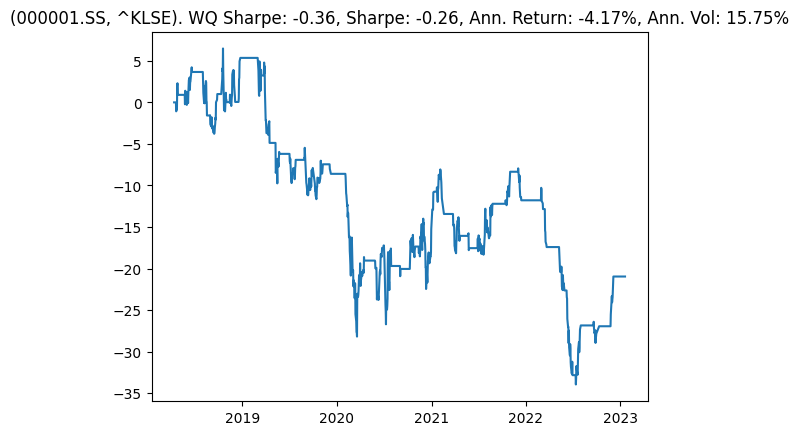

Selected pair: 000001.SS and ^STI.
[*********************100%***********************]  2 of 2 completed


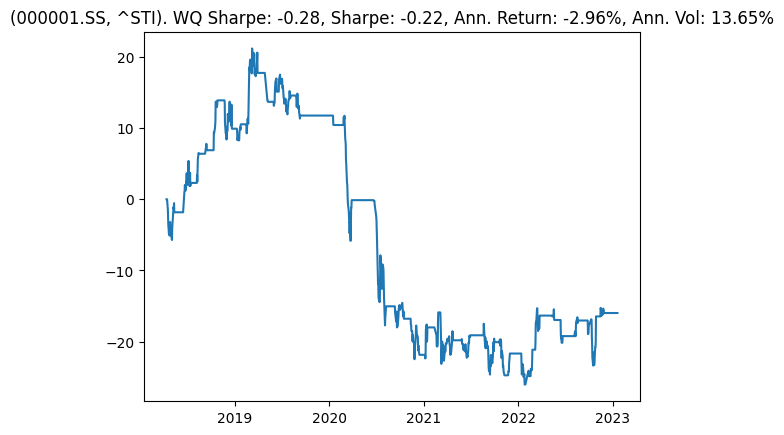

Selected pair: 000001.SS and ^TWII.
[*********************100%***********************]  2 of 2 completed


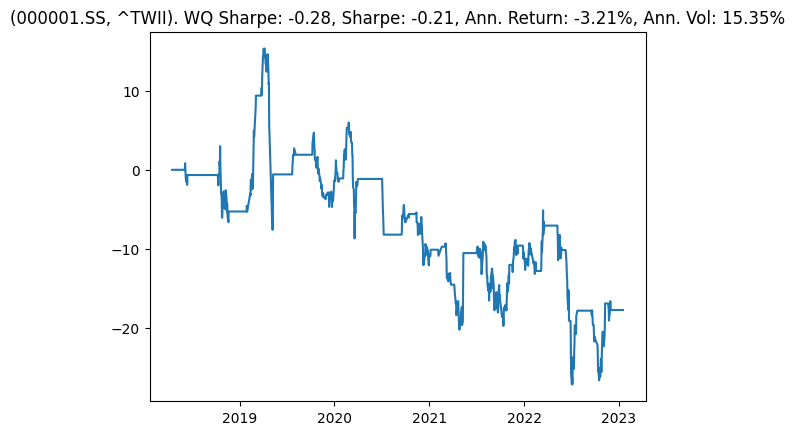

Selected pair: 000001.SS and ^XAX.
[*********************100%***********************]  2 of 2 completed


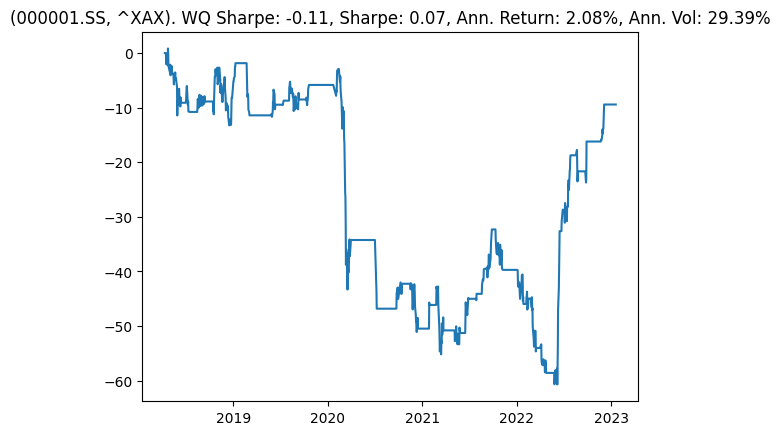

Selected pair: 399001.SZ and ^KLSE.
[*********************100%***********************]  2 of 2 completed


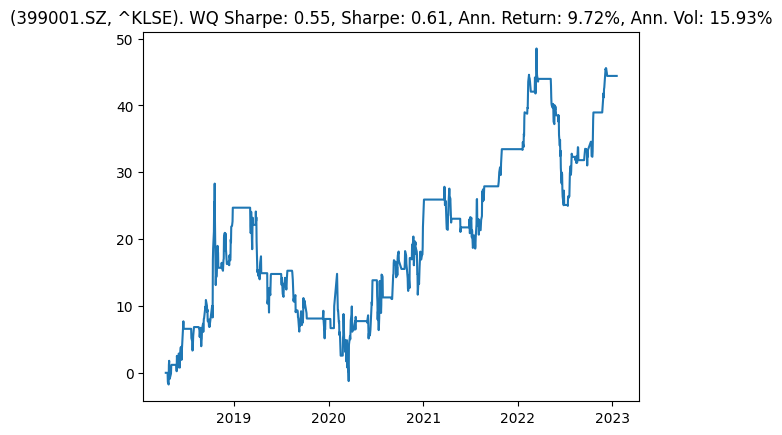

Selected pair: 399001.SZ and ^STI.
[*********************100%***********************]  2 of 2 completed


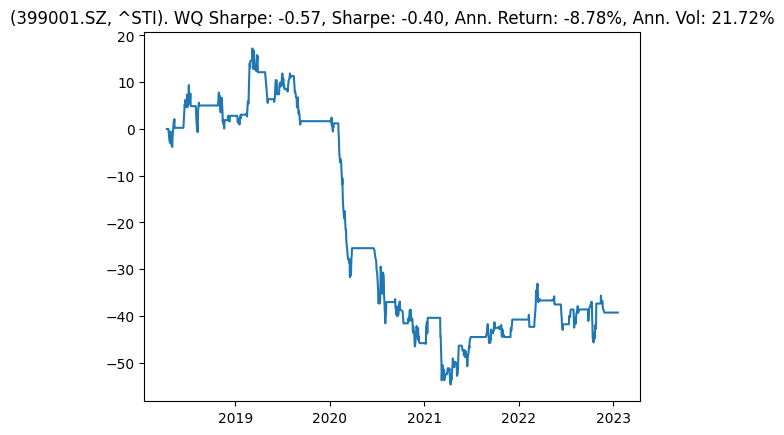

Selected pair: 399001.SZ and ^TWII.
[*********************100%***********************]  2 of 2 completed


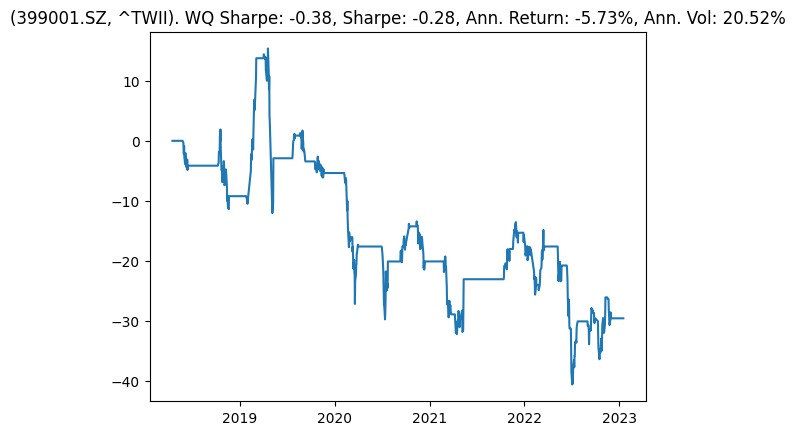

Selected pair: 399001.SZ and ^XAX.
[*********************100%***********************]  2 of 2 completed


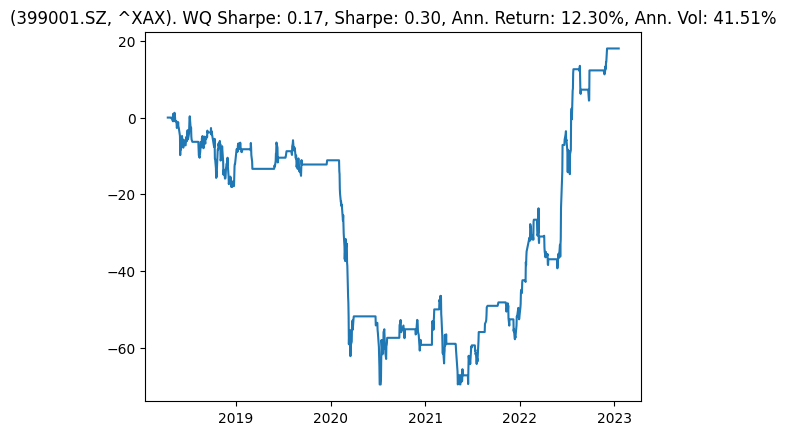

Selected pair: ^AORD and ^BFX.
[*********************100%***********************]  2 of 2 completed


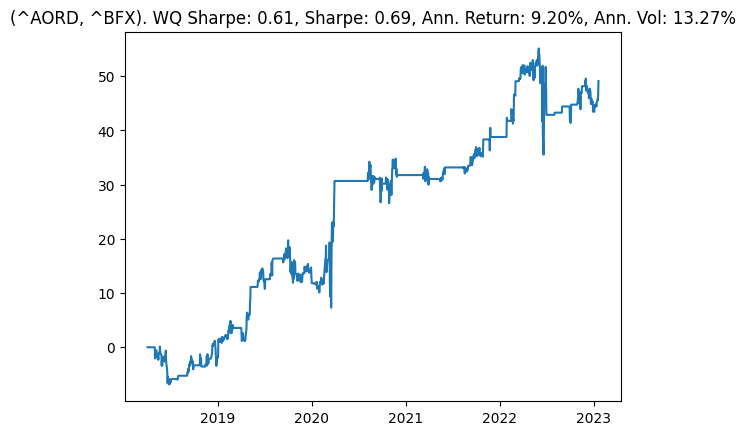

Selected pair: ^AORD and ^BSESN.
[*********************100%***********************]  2 of 2 completed


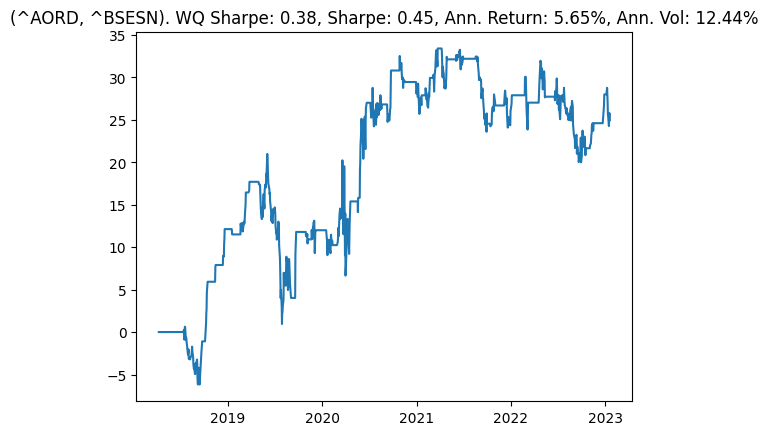

Selected pair: ^AORD and ^FCHI.
[*********************100%***********************]  2 of 2 completed


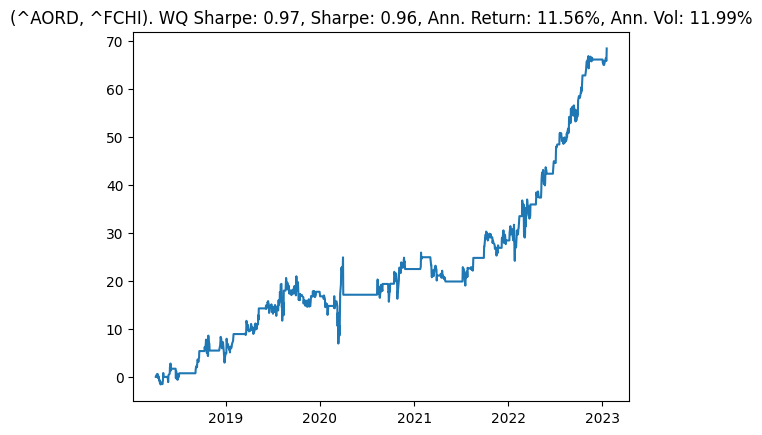

Selected pair: ^AORD and ^FTSE.
[*********************100%***********************]  2 of 2 completed


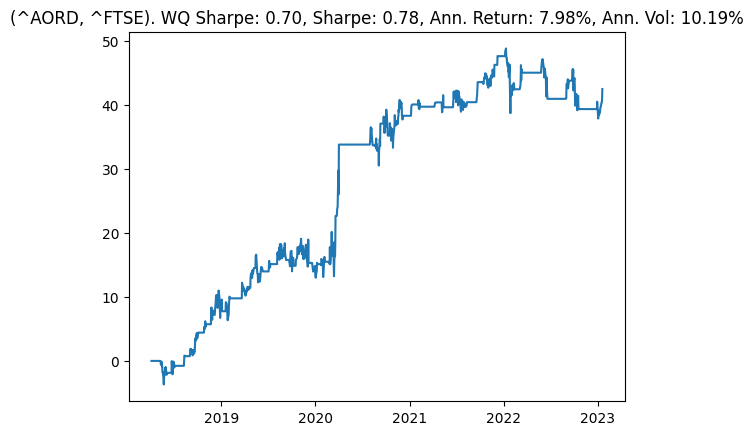

Selected pair: ^AORD and ^GDAXI.
[*********************100%***********************]  2 of 2 completed


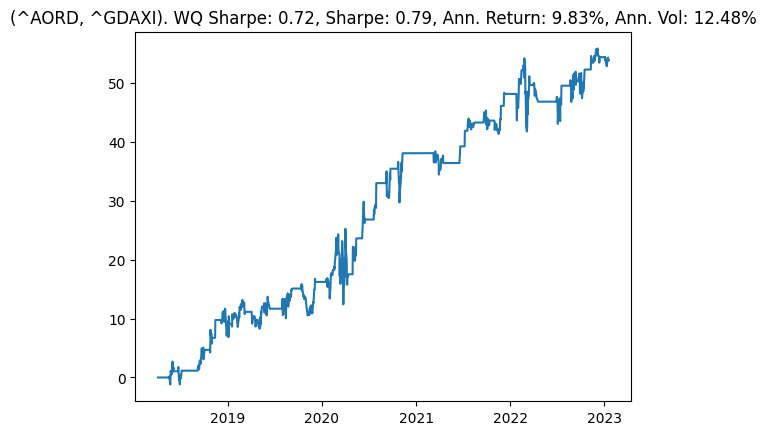

Selected pair: ^AORD and ^MERV.
[*********************100%***********************]  2 of 2 completed


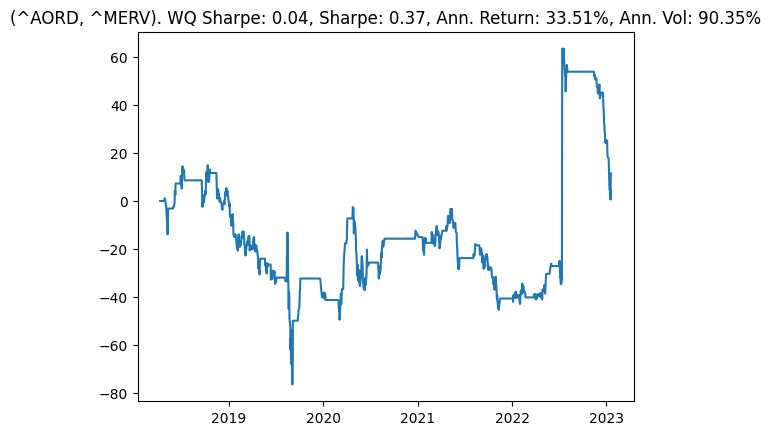

Selected pair: ^AORD and ^N100.
[*********************100%***********************]  2 of 2 completed


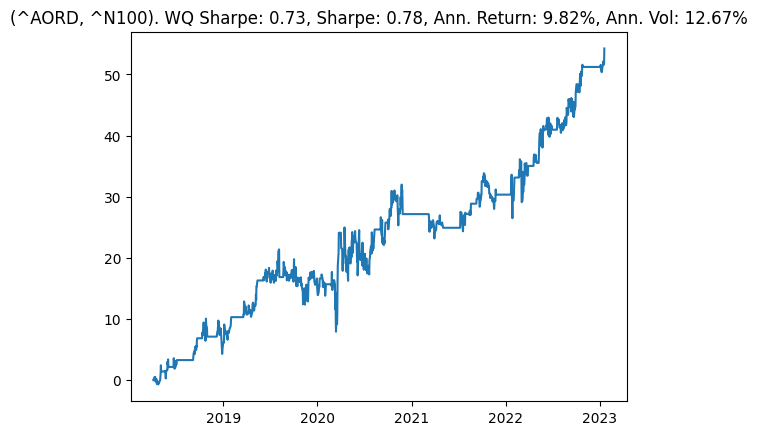

Selected pair: ^AORD and ^N225.
[*********************100%***********************]  2 of 2 completed


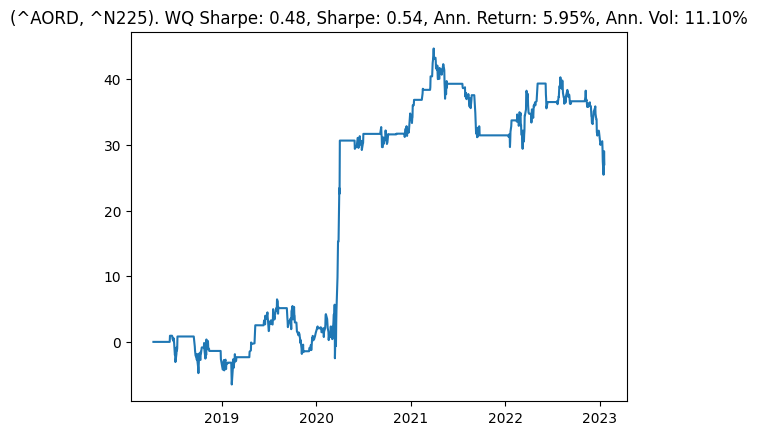

Selected pair: ^AORD and ^NYA.
[*********************100%***********************]  2 of 2 completed


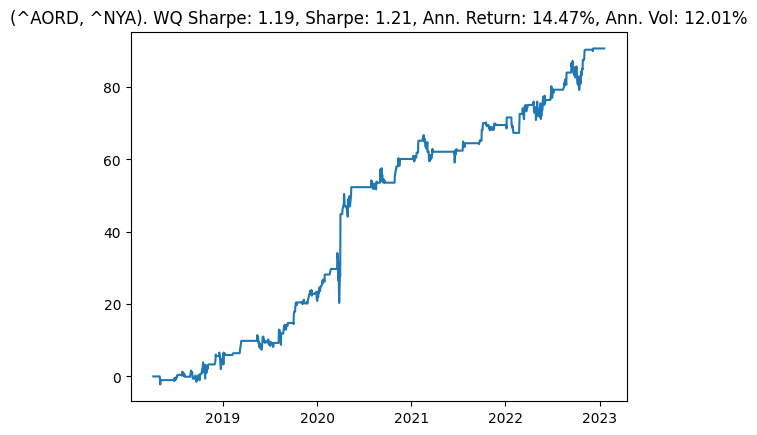

Selected pair: ^AORD and ^RUT.
[*********************100%***********************]  2 of 2 completed


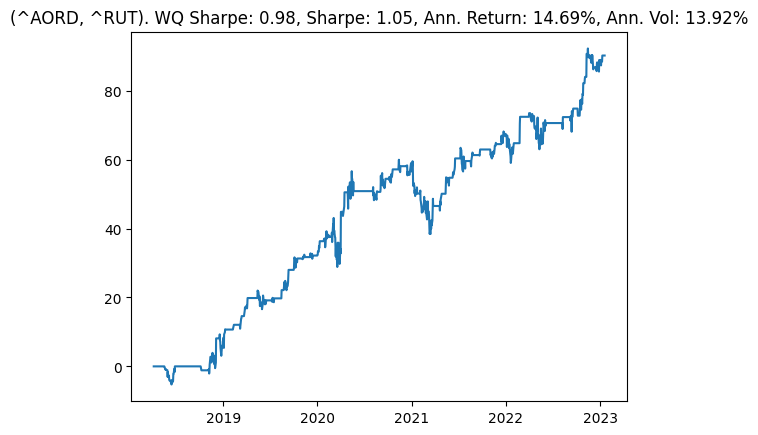

Selected pair: ^AXJO and ^BFX.
[*********************100%***********************]  2 of 2 completed


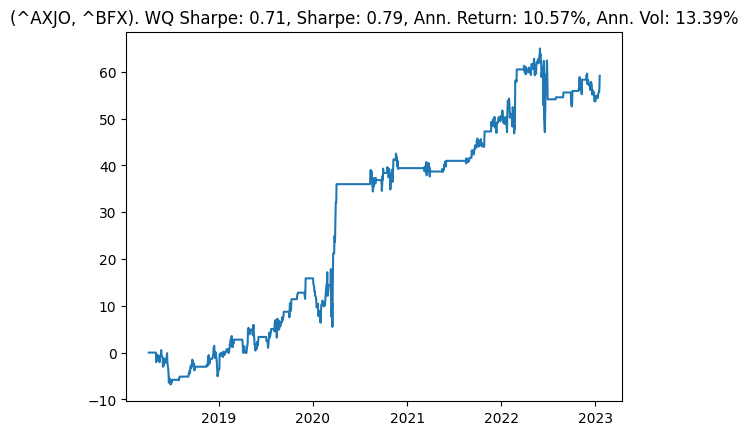

Selected pair: ^AXJO and ^FCHI.
[*********************100%***********************]  2 of 2 completed


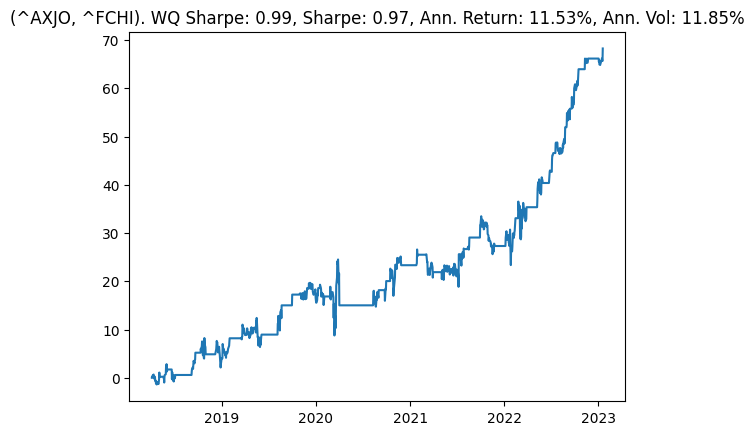

Selected pair: ^AXJO and ^FTSE.
[*********************100%***********************]  2 of 2 completed


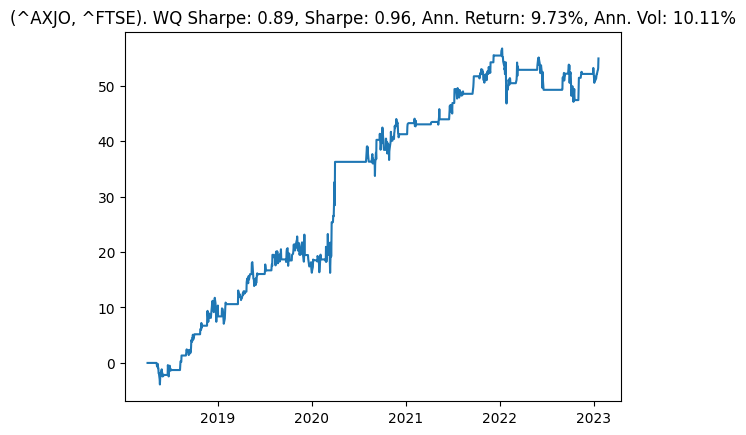

Selected pair: ^AXJO and ^GDAXI.
[*********************100%***********************]  2 of 2 completed


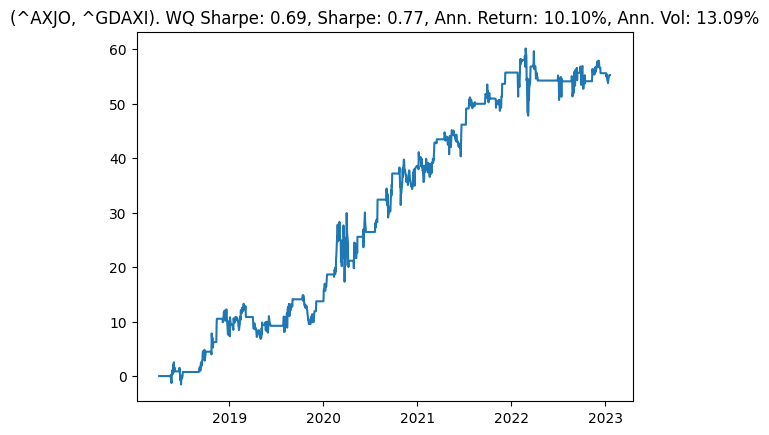

Selected pair: ^AXJO and ^MERV.
[*********************100%***********************]  2 of 2 completed


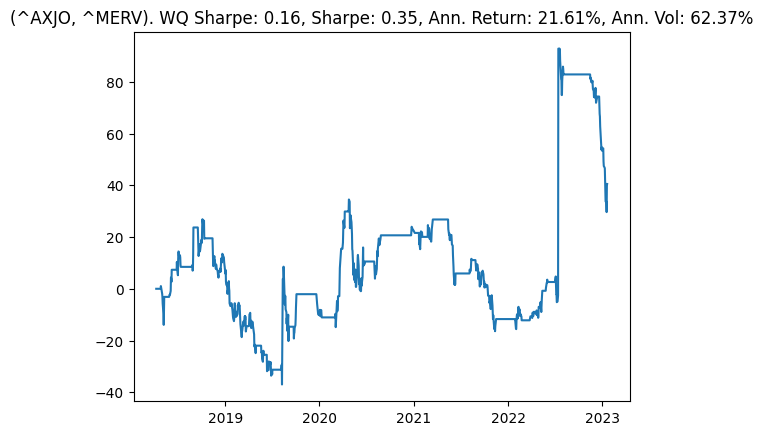

Selected pair: ^AXJO and ^N100.
[*********************100%***********************]  2 of 2 completed


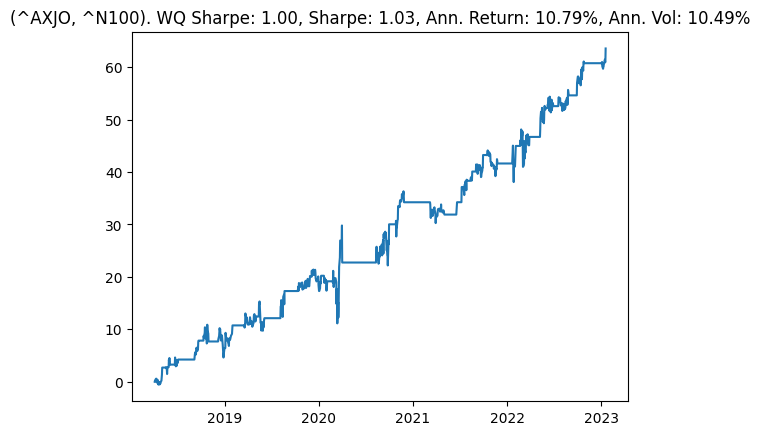

Selected pair: ^AXJO and ^N225.
[*********************100%***********************]  2 of 2 completed


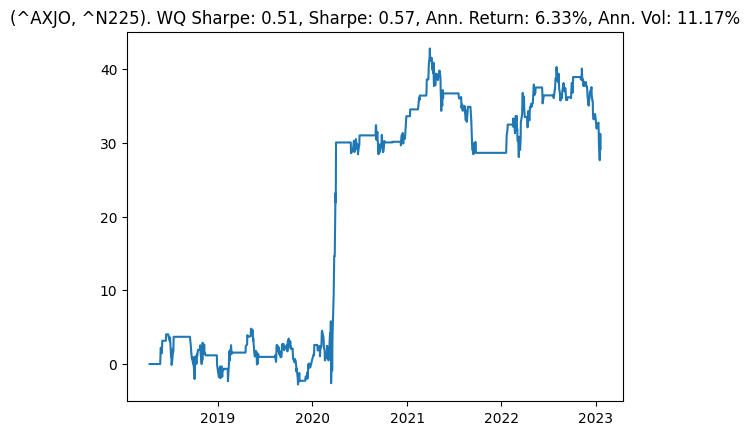

Selected pair: ^AXJO and ^NYA.
[*********************100%***********************]  2 of 2 completed


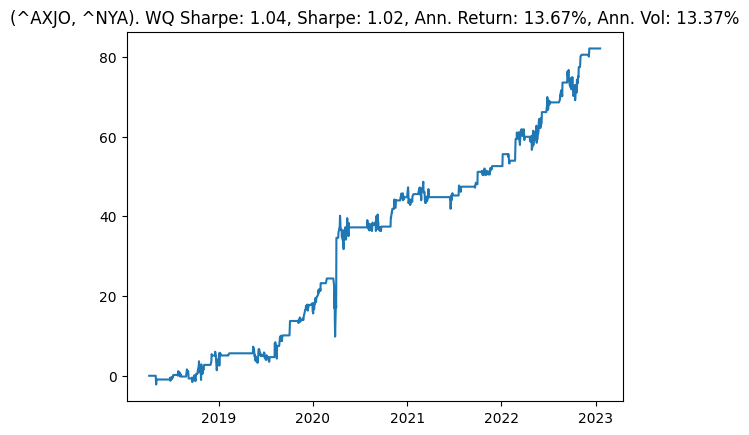

Selected pair: ^AXJO and ^RUT.
[*********************100%***********************]  2 of 2 completed


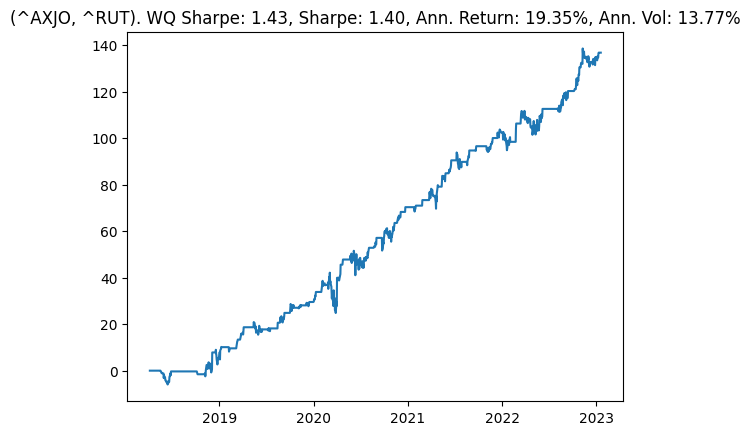

Selected pair: ^BFX and ^BSESN.
[*********************100%***********************]  2 of 2 completed


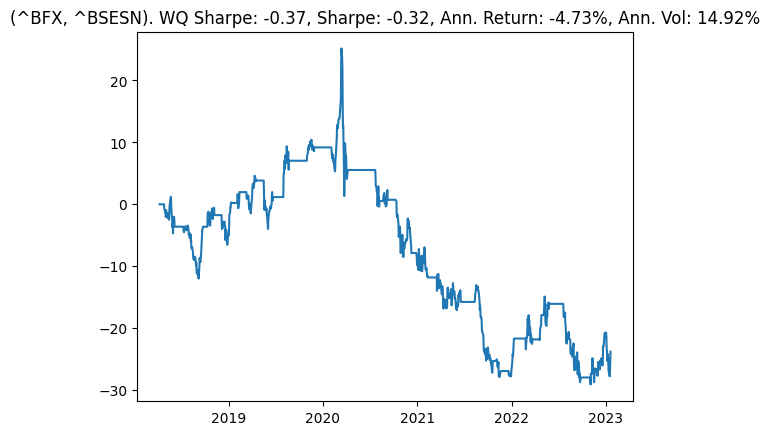

Selected pair: ^BSESN and ^FCHI.
[*********************100%***********************]  2 of 2 completed


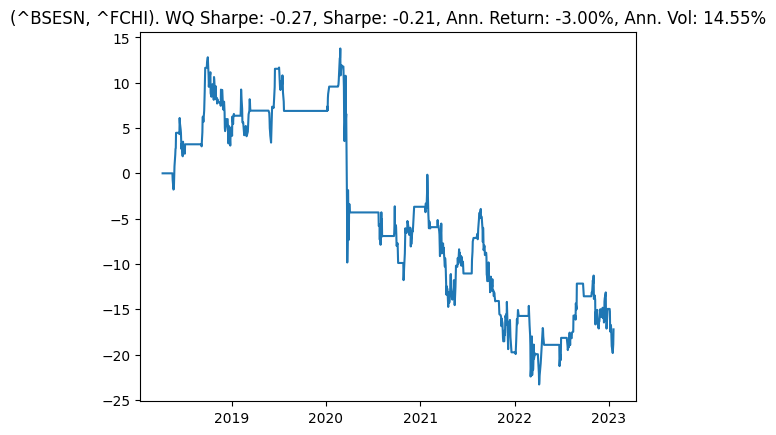

Selected pair: ^BSESN and ^MERV.
[*********************100%***********************]  2 of 2 completed


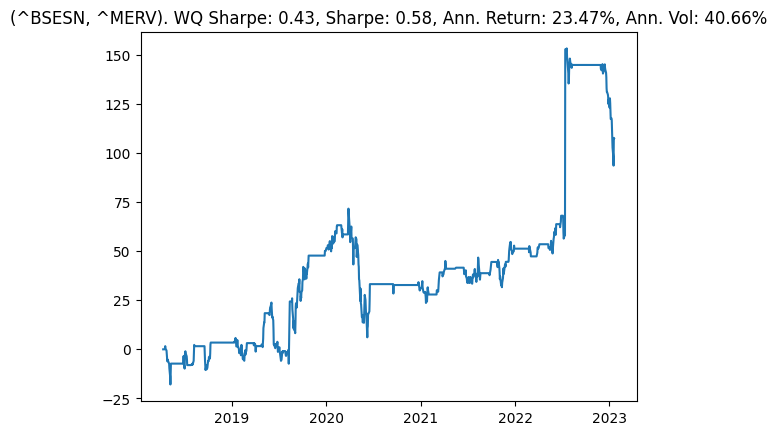

Selected pair: ^BSESN and ^N100.
[*********************100%***********************]  2 of 2 completed


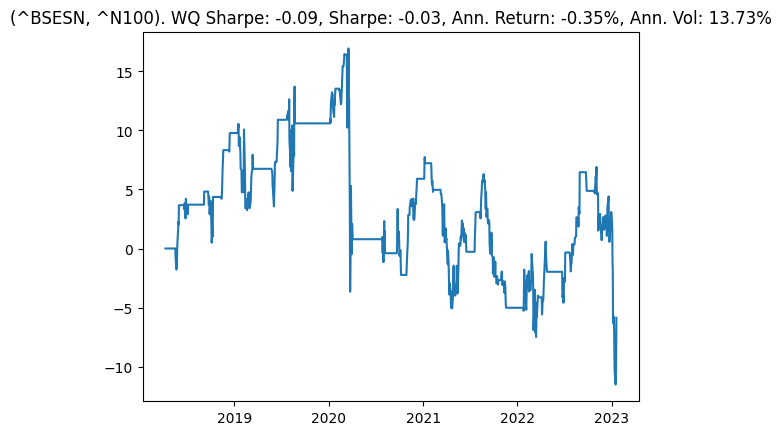

Selected pair: ^BVSP and ^IPSA.
[*********************100%***********************]  2 of 2 completed


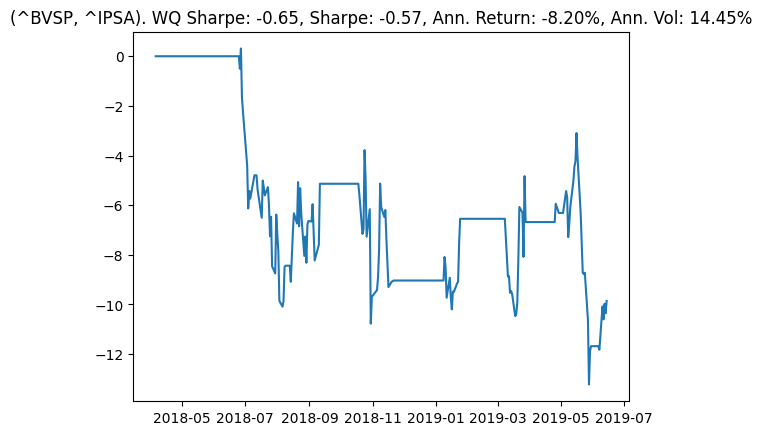

Selected pair: ^DJI and ^FTSE.
[*********************100%***********************]  2 of 2 completed


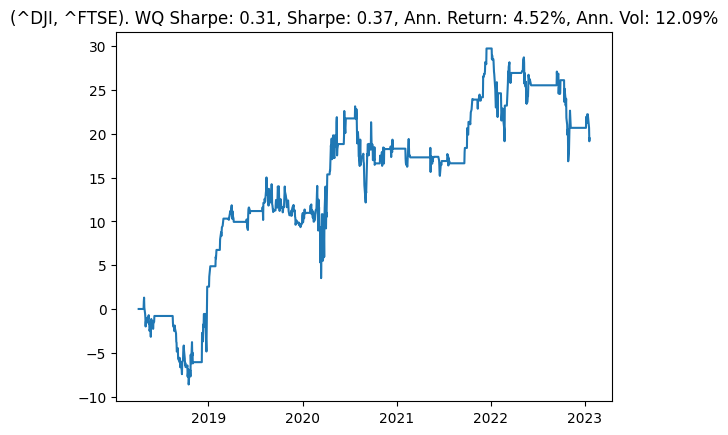

Selected pair: ^DJI and ^MXX.
[*********************100%***********************]  2 of 2 completed


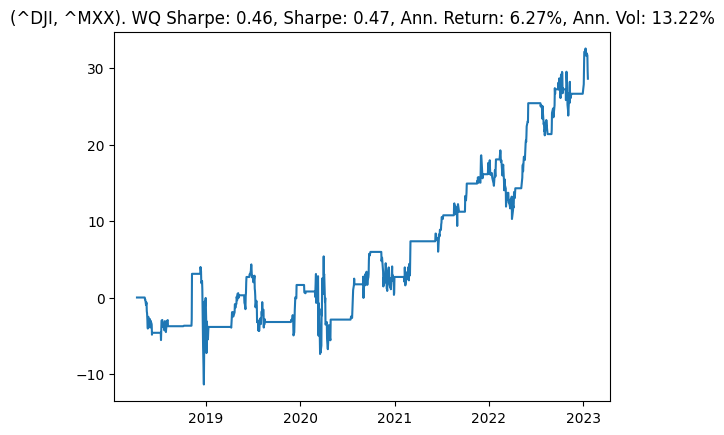

Selected pair: ^FCHI and ^MERV.
[*********************100%***********************]  2 of 2 completed


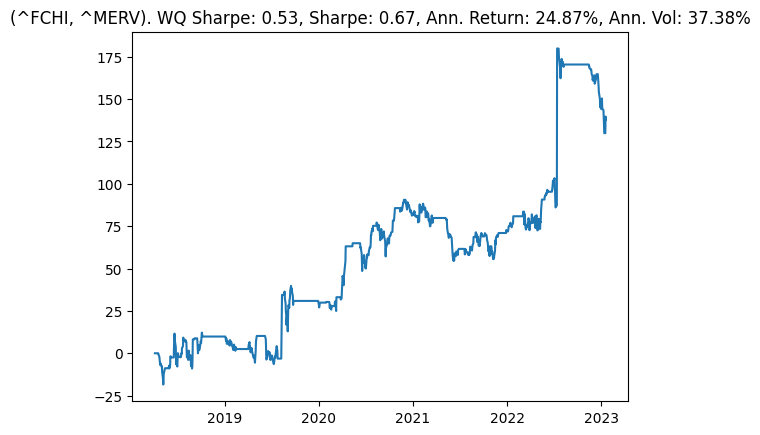

Selected pair: ^FCHI and ^N225.
[*********************100%***********************]  2 of 2 completed


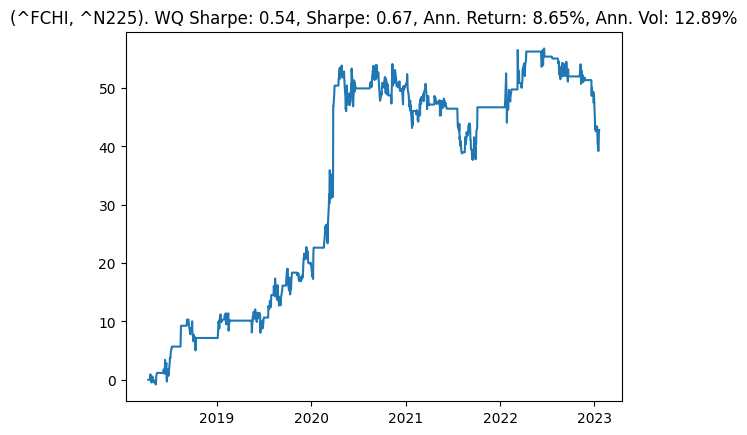

Selected pair: ^FTSE and ^GDAXI.
[*********************100%***********************]  2 of 2 completed


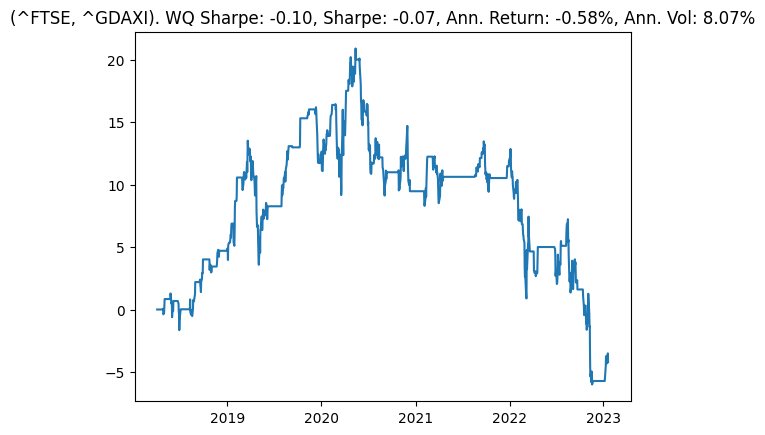

Selected pair: ^FTSE and ^GSPC.
[*********************100%***********************]  2 of 2 completed


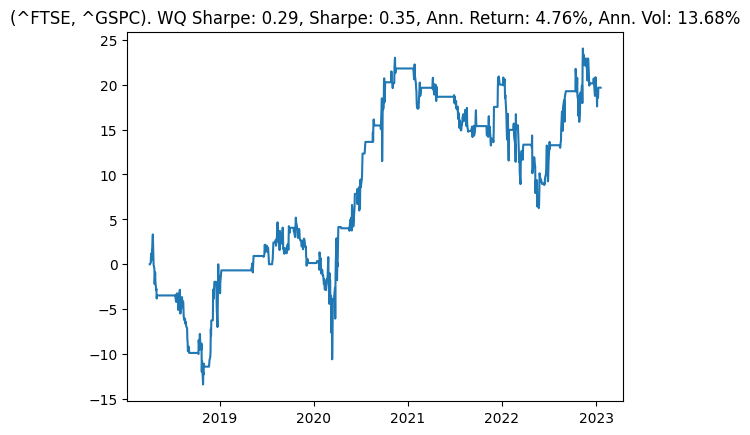

Selected pair: ^FTSE and ^HSI.
[*********************100%***********************]  2 of 2 completed


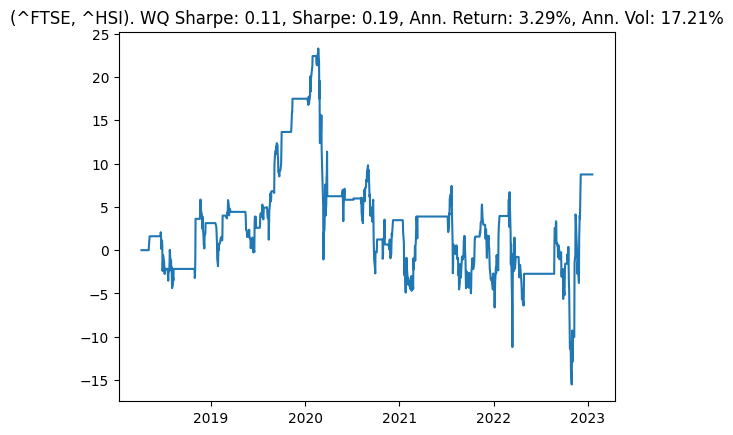

Selected pair: ^FTSE and ^IXIC.
[*********************100%***********************]  2 of 2 completed


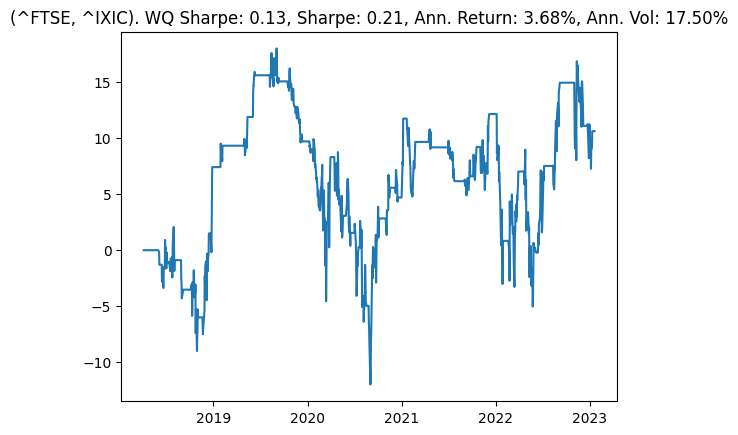

Selected pair: ^FTSE and ^JKSE.
[*********************100%***********************]  2 of 2 completed


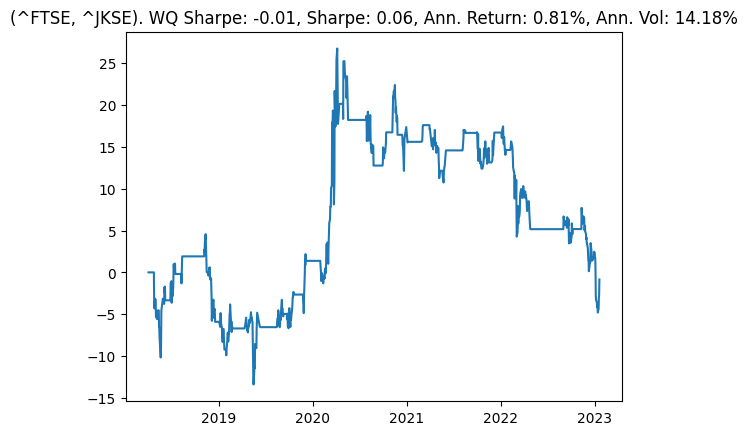

Selected pair: ^FTSE and ^MERV.
[*********************100%***********************]  2 of 2 completed


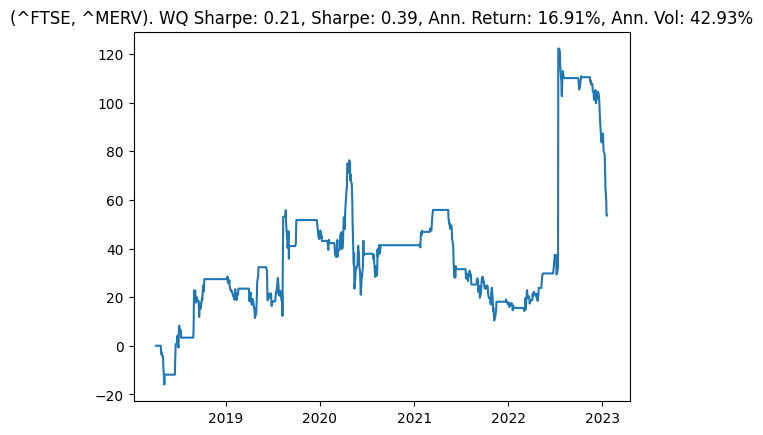

Selected pair: ^FTSE and ^N225.
[*********************100%***********************]  2 of 2 completed


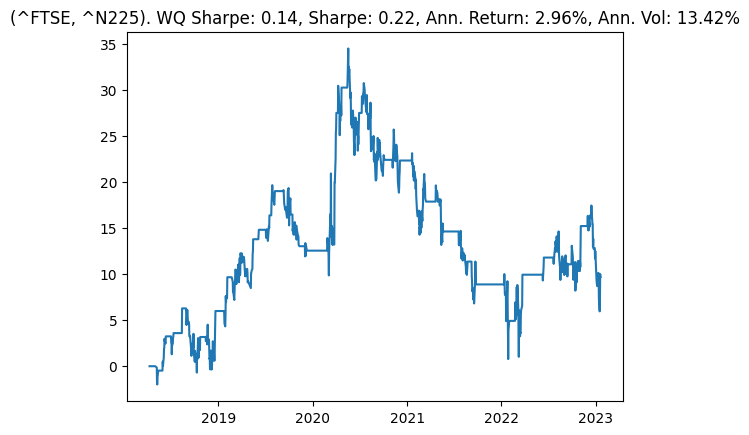

Selected pair: ^FTSE and ^NYA.
[*********************100%***********************]  2 of 2 completed


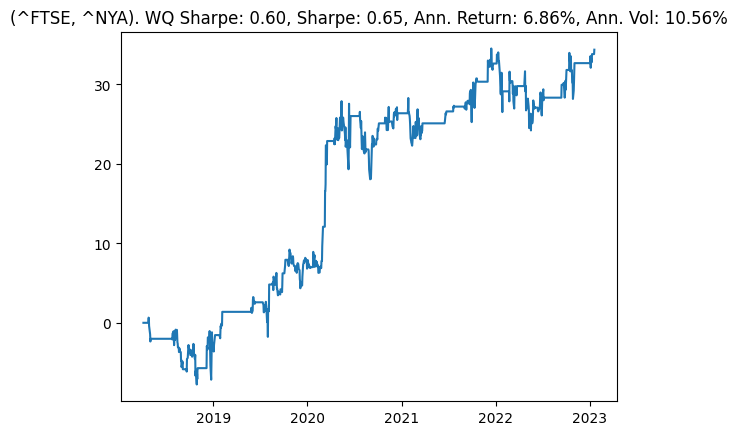

Selected pair: ^FTSE and ^NZ50.
[*********************100%***********************]  2 of 2 completed


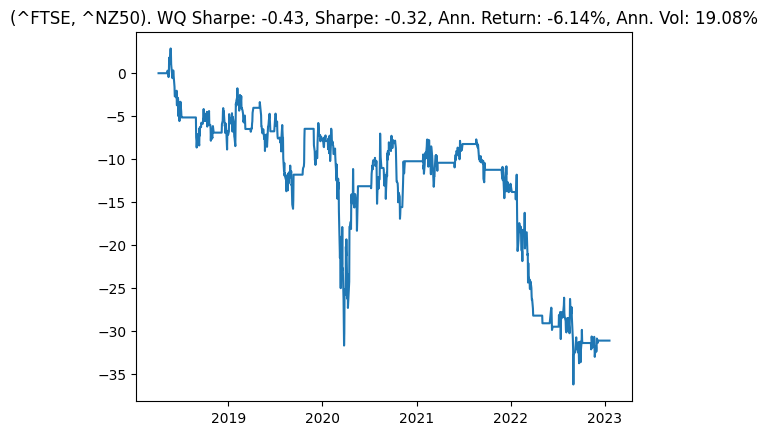

Selected pair: ^FTSE and ^RUT.
[*********************100%***********************]  2 of 2 completed


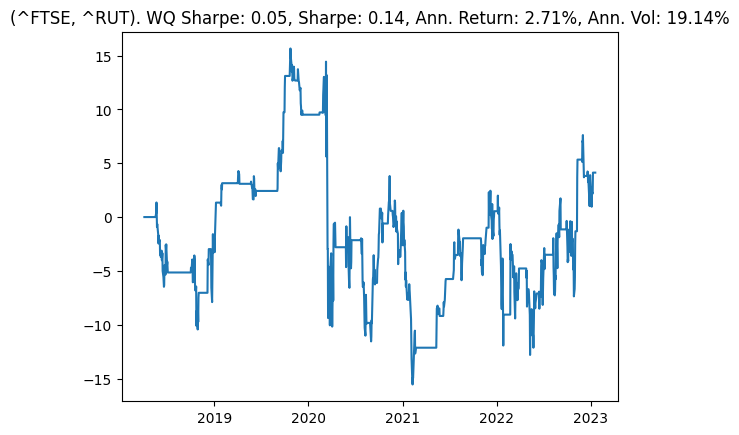

Selected pair: ^FTSE and ^TWII.
[*********************100%***********************]  2 of 2 completed


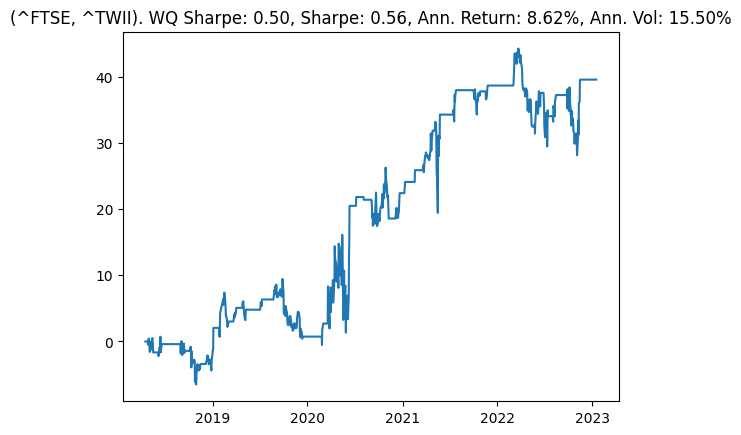

Selected pair: ^GDAXI and ^N225.
[*********************100%***********************]  2 of 2 completed


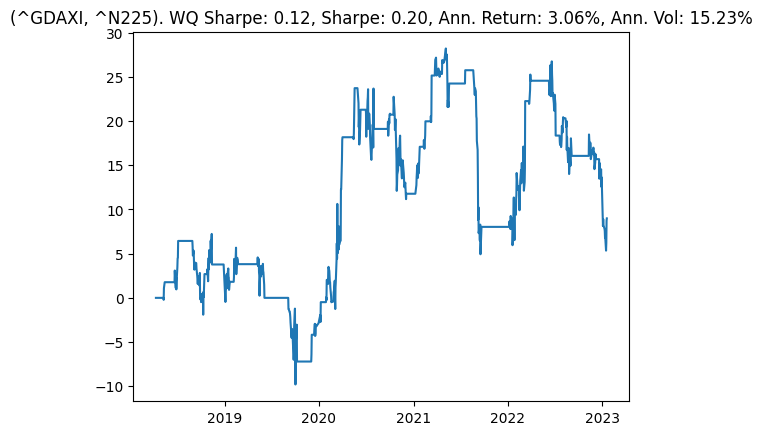

Selected pair: ^GDAXI and ^RUT.
[*********************100%***********************]  2 of 2 completed


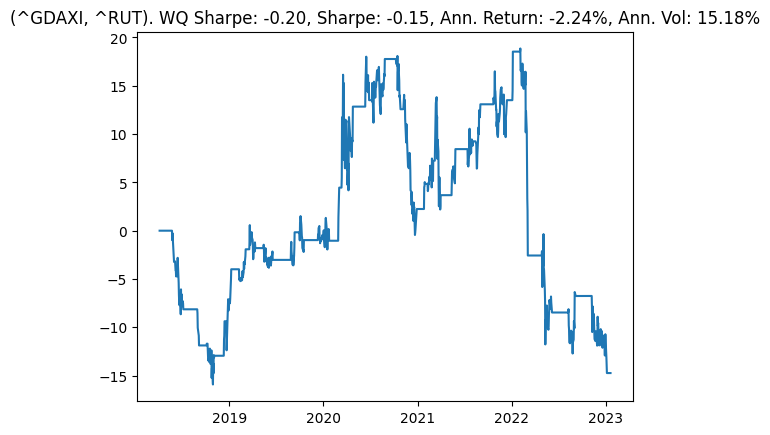

Selected pair: ^GSPC and ^MXX.
[*********************100%***********************]  2 of 2 completed


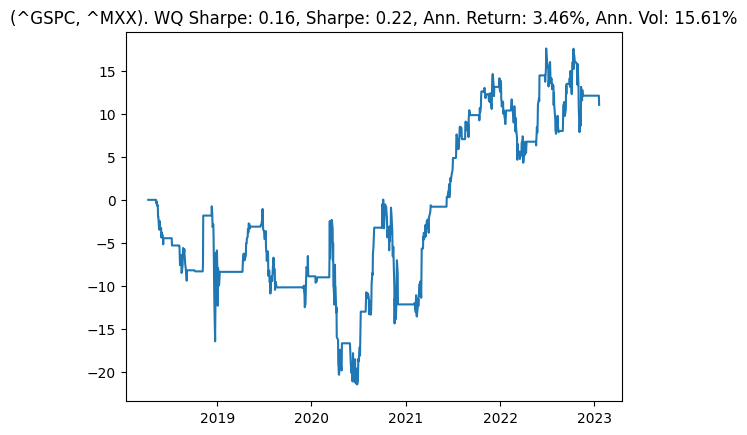

Selected pair: ^GSPTSE and ^TWII.
[*********************100%***********************]  2 of 2 completed


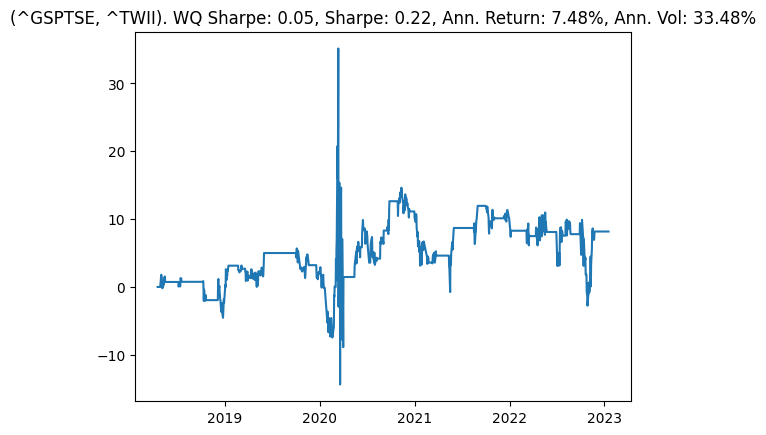

Selected pair: ^HSI and ^TWII.
[*********************100%***********************]  2 of 2 completed


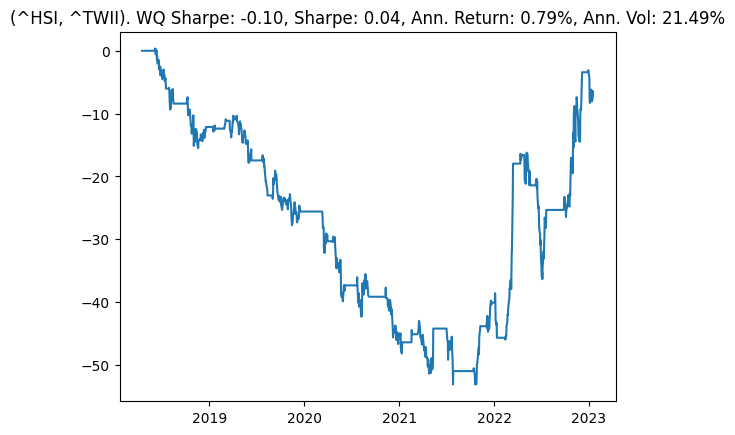

Selected pair: ^HSI and ^XAX.
[*********************100%***********************]  2 of 2 completed


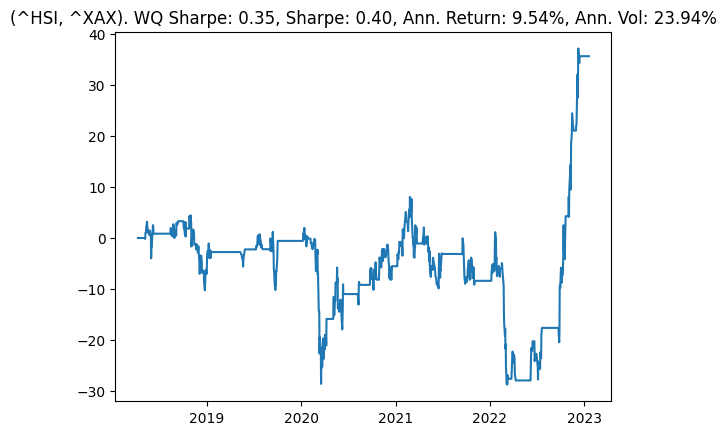

Selected pair: ^IXIC and ^MXX.
[*********************100%***********************]  2 of 2 completed


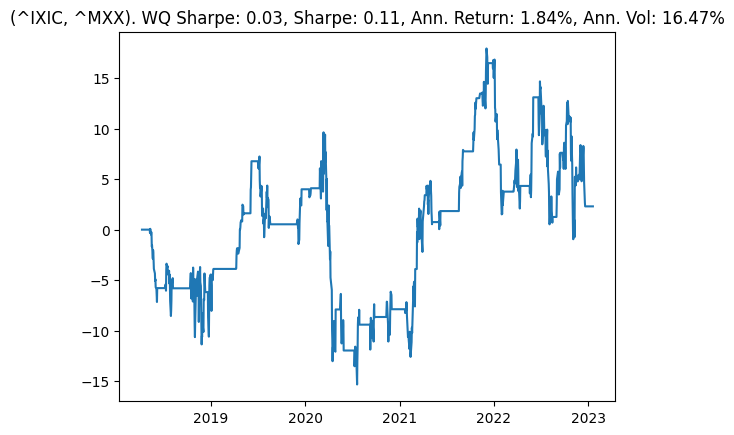

Selected pair: ^JKSE and ^MXX.
[*********************100%***********************]  2 of 2 completed


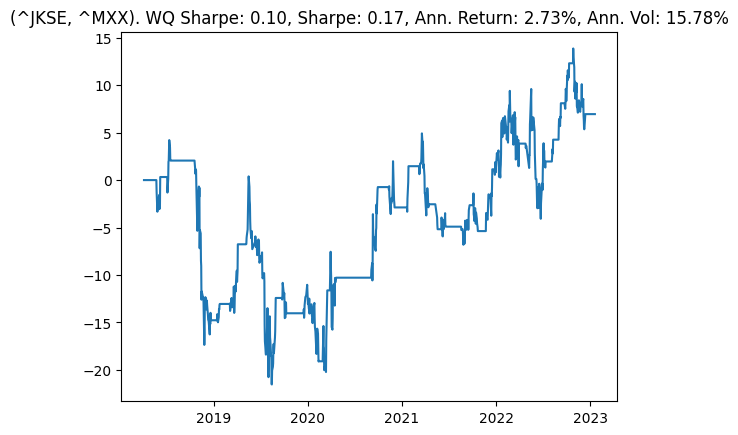

Selected pair: ^JKSE and ^XAX.
[*********************100%***********************]  2 of 2 completed


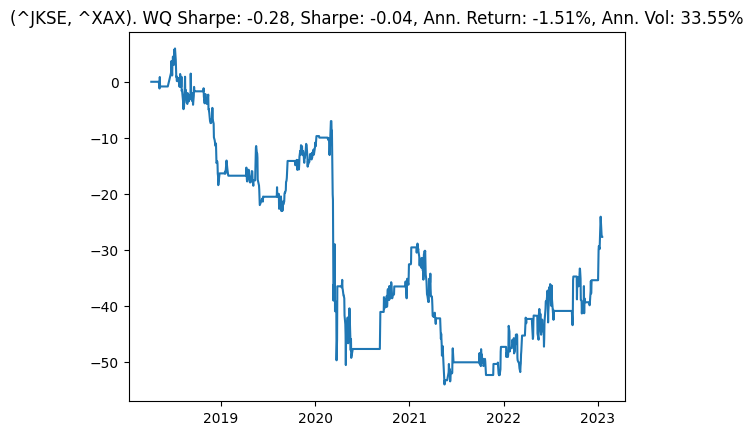

Selected pair: ^KLSE and ^XAX.
[*********************100%***********************]  2 of 2 completed


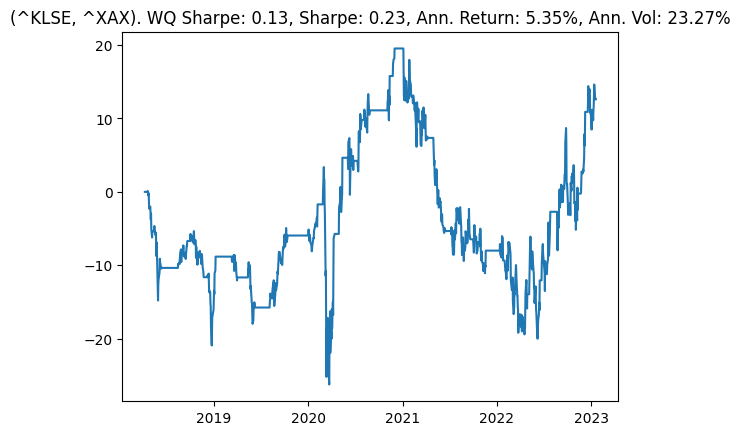

Selected pair: ^MERV and ^MXX.
[*********************100%***********************]  2 of 2 completed


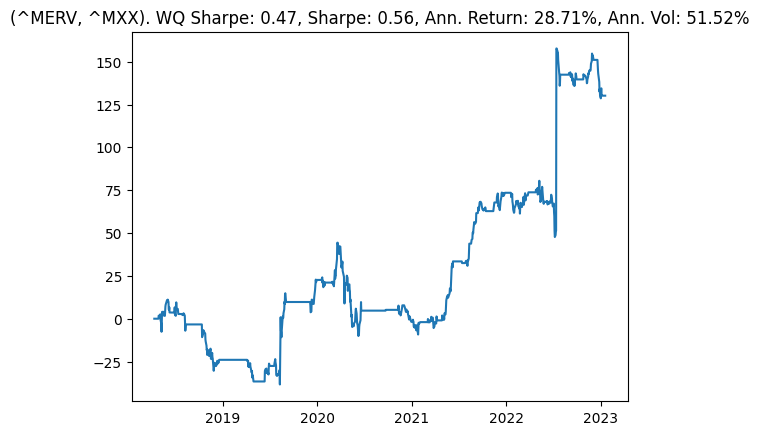

Selected pair: ^MERV and ^N100.
[*********************100%***********************]  2 of 2 completed


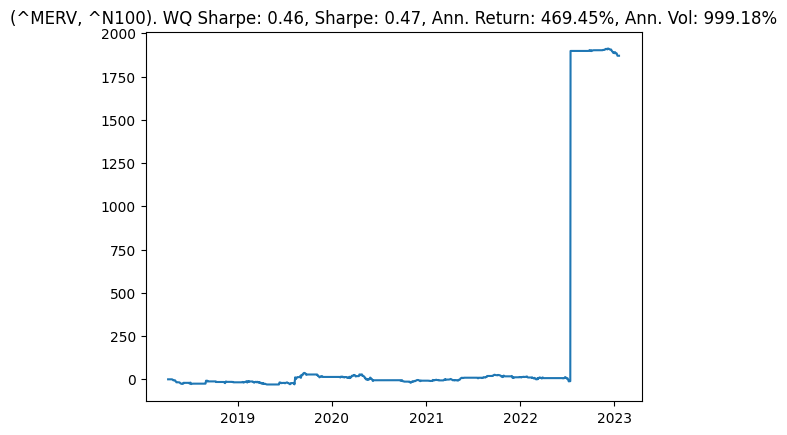

Selected pair: ^MXX and ^N225.
[*********************100%***********************]  2 of 2 completed


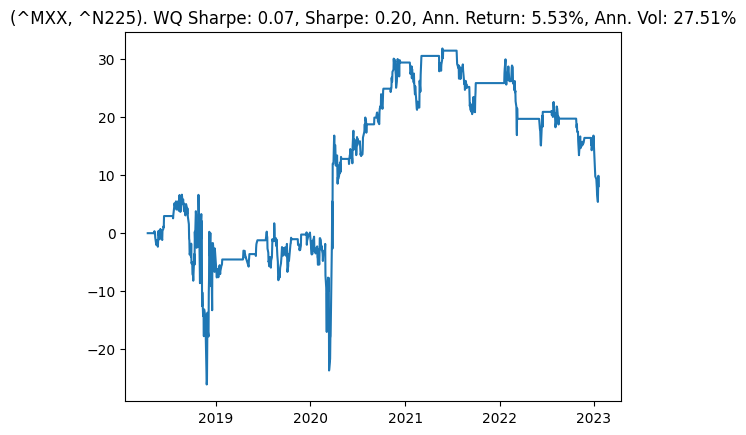

Selected pair: ^MXX and ^NZ50.
[*********************100%***********************]  2 of 2 completed


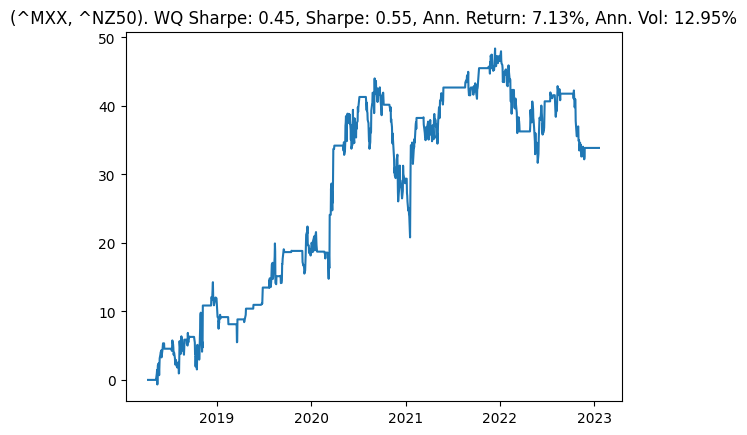

Selected pair: ^MXX and ^RUT.
[*********************100%***********************]  2 of 2 completed


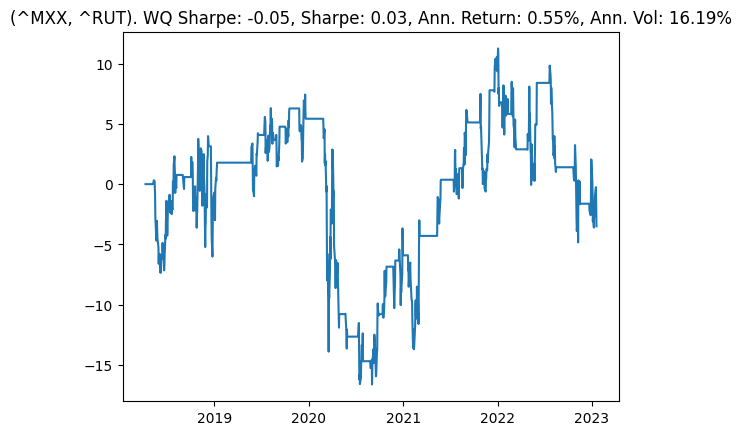

Selected pair: ^N100 and ^N225.
[*********************100%***********************]  2 of 2 completed


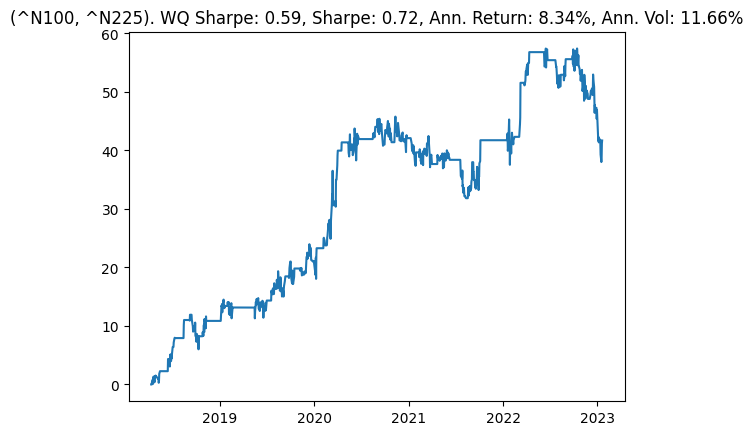

Selected pair: ^N225 and ^NYA.
[*********************100%***********************]  2 of 2 completed


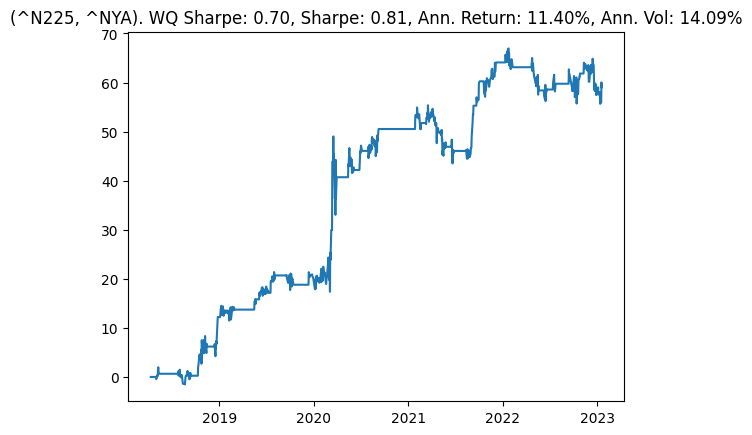

Selected pair: ^N225 and ^XAX.
[*********************100%***********************]  2 of 2 completed


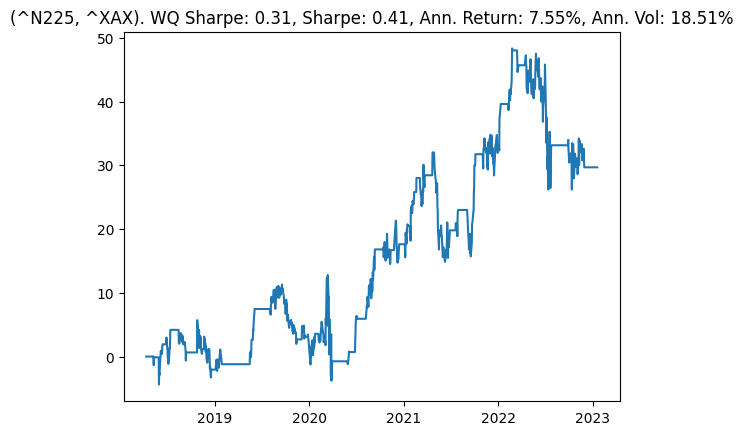

Selected pair: ^NYA and ^RUT.
[*********************100%***********************]  2 of 2 completed


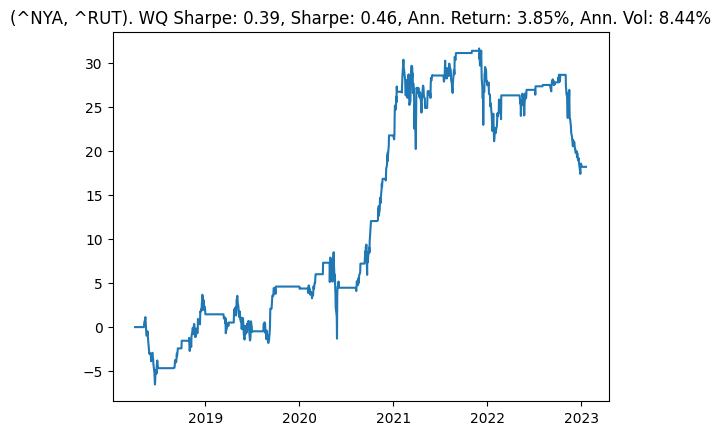

Selected pair: ^STI and ^XAX.
[*********************100%***********************]  2 of 2 completed


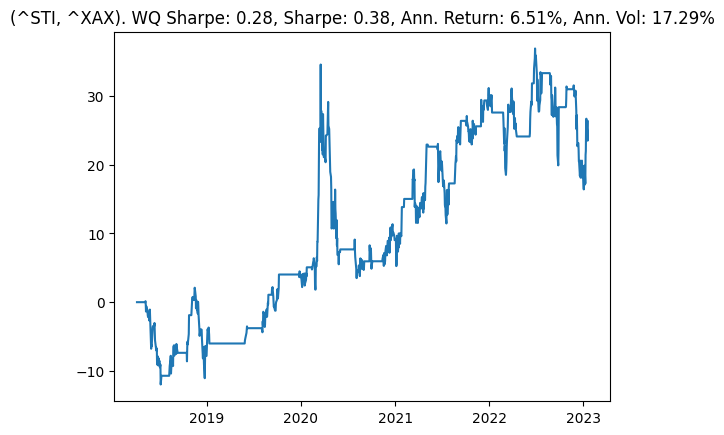

In [10]:
# Dynamic threshold based pairs trading (based on trade function)
results = {}
pnl_results = {}
for asset1, asset2 in selected_pairs:
    print(f"Selected pair: {asset1} and {asset2}.")
    pairs_data = yf.download(f"{asset1} {asset2}", start="2018-01-02", end="2023-01-20")
    prices_df = pairs_data["Adj Close"].dropna()
    forward_returns_df = prices_df.pct_change().iloc[1:]
    pairs_trader = DynamicThresholdPairsTrader(prices_df)
    actions_df_dynamic_thresh = pairs_trader.backtest_actions(
        formation_period=63, testing_period=21,
        entry_threshold=2.0, exit_threshold=0.0
    )
    dollar_portfolios = pairs_trader.pnl_actions(
        actions_df_dynamic_thresh,
        future_returns_df=forward_returns_df,
    )
    offset = 100
    pnl = dollar_portfolios.sum(axis=1) + offset 
    returns = pnl.pct_change()
    daily_returns = returns.mean()
    ann_returns = 252 * daily_returns*100
    daily_vol = returns.std()
    ann_vol = np.sqrt(252) * daily_vol*100
    sharpe = ann_returns / ann_vol
    wq_sharpe = np.sqrt(252) * (pnl - pnl.shift(1)).mean() / (pnl - pnl.shift(1)).std()
    plt.figure()
    plt.plot(pnl-offset)
    plt.title(f"({asset1}, {asset2}). WQ Sharpe: {wq_sharpe:.2f}, Sharpe: {sharpe:.2f}, "
              f"Ann. Return: {ann_returns:.2f}%, "
              f"Ann. Vol: {ann_vol:.2f}%")
    plt.show()
    results.update({f"{asset1}-{asset2}": {"WQ Sharpe": wq_sharpe, #World Quant Sharpe
                                           "Sharpe" : sharpe,
                                           "Ann.Ret" : ann_returns,
                                           "Ann.Vol" : ann_vol}})
    pnl_results.update({f"{asset1}-{asset2}": pnl-offset})

In [11]:
import pandas as pd
results_df = pd.DataFrame(results).T
results_df.sort_values("WQ Sharpe", ascending=False).iloc[:15]

WQ Sharpe    Sharpe    Ann.Ret    Ann.Vol
^AXJO-^RUT     1.431863  1.404693  19.349466  13.774869
^AORD-^NYA     1.194620  1.205500  14.474663  12.007188
^AXJO-^NYA     1.037902  1.022689  13.673331  13.369986
^AXJO-^N100    0.998302  1.028062  10.789230  10.494725
^AXJO-^FCHI    0.986418  0.972810  11.529121  11.851360
^AORD-^RUT     0.976249  1.054778  14.686701  13.923977
^AORD-^FCHI    0.973122  0.964255  11.562555  11.991175
^AXJO-^FTSE    0.893942  0.962722   9.733176  10.110057
^AORD-^N100    0.728827  0.775153   9.821511  12.670420
^AORD-^GDAXI   0.722459  0.787658   9.833845  12.484924
^AXJO-^BFX     0.711912  0.789662  10.570785  13.386476
^AORD-^FTSE    0.703839  0.783047   7.980521  10.191628
^N225-^NYA     0.700528  0.809176  11.401954  14.090829
^AXJO-^GDAXI   0.687847  0.771240  10.096063  13.090684
^AORD-^BFX     0.609927  0.693320   9.200122  13.269657

In [12]:
top_10_pairs = results_df.sort_values("WQ Sharpe", ascending=False).iloc[:10].index
print("Top 10 pairs", top_10_pairs )
top_10_pnl = {}
for pair in top_10_pairs:
    top_10_pnl.update({pair : pnl_results[pair]})

Top 10 pairs Index(['^AXJO-^RUT', '^AORD-^NYA', '^AXJO-^NYA', '^AXJO-^N100', '^AXJO-^FCHI',
       '^AORD-^RUT', '^AORD-^FCHI', '^AXJO-^FTSE', '^AORD-^N100',
       '^AORD-^GDAXI'],
      dtype='object')


Text(0.5, 1.0, 'Avg top 10. WQ Sharpe: 1.63. Sharpe: 1.64. Ann. Return: 12.03%. Ann. Vol: 7.35%.')

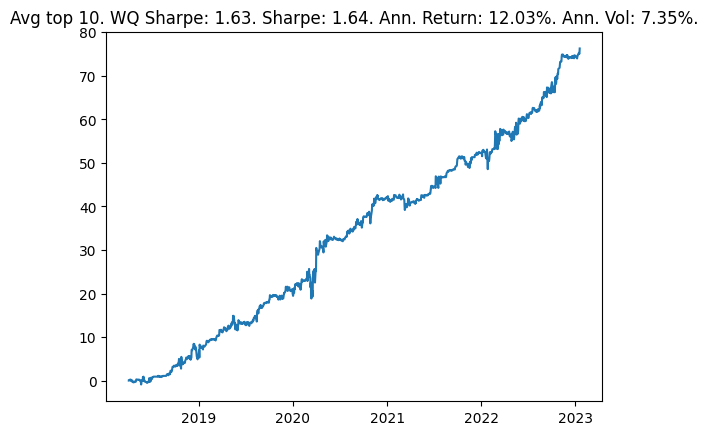

In [14]:
avg_pnl = pd.DataFrame(top_10_pnl).fillna(method="ffill").mean(axis=1)
avg_pnl_offset = avg_pnl + 100
avg_returns = avg_pnl_offset.pct_change().iloc[1:]
avg_daily_return = avg_returns.mean()*252*100
avg_daily_vol = avg_returns.std()*np.sqrt(252)*100
avg_sharpe = avg_daily_return / avg_daily_vol
avg_wq_sharpe = np.sqrt(252) * (avg_pnl - avg_pnl.shift(1)).mean() / (avg_pnl - avg_pnl.shift(1)).std()

plt.figure()
plt.plot(avg_pnl)
plt.title(f"Avg top 10. WQ Sharpe: {avg_wq_sharpe:.2f}. "
          f"Sharpe: {avg_sharpe:.2f}. "
          f"Ann. Return: {avg_daily_return:.2f}%. "
          f"Ann. Vol: {avg_daily_vol:.2f}%.")